<a href="https://colab.research.google.com/github/willmbennett/meld_calc/blob/dev/mimic_iv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying Machine Learning to End Stage Liver Disease
Student: Will Bennett

Instructor: David Elliot

Active Project Dates: June 26th - July 13th

## Intro

The Mayo End-Stage Liver Disease (MELD) score is the current accepted score and is used to prioritize organ allocation for liver transplantation. The MELD score is widely accepted and highly validated, and is continually improved.

This project will be applying machine learning techniques to predict outcomes in patients with end stage liver disease with the hope of outperforming the MELD model.

References:
- [Meld Score MDCALc](https://www.mdcalc.com/calc/10437/model-end-stage-liver-disease-meld?utm_source=site&utm_medium=link&utm_campaign=meld_12_and_older)
- [Original development](https://pubmed.ncbi.nlm.nih.gov/11172350/)
- [Meld-NA improvement](https://pubmed.ncbi.nlm.nih.gov/18768945/)
- [Meld 3.0 (current)](https://pubmed.ncbi.nlm.nih.gov/34481845/)

**Project Inspiration**

Introducing [MDCalc](https://www.mdcalc.com/)

> "MDCalc is a free online medical reference for healthcare professionals that provides point-of-care clinical decision-support tools, including medical calculators, scoring systems, and algorithms." - [Wikipedia](https://en.wikipedia.org/wiki/MDCalc)

**Business Case**

*Disclaimer: this case is imaginary*

Beth Israel Deaconess Medical Center is looking to improve on their outcomes for patients with end stage liver disease. To do that they've asked me to come up with an improved method of predicting outcomes (compared to MELD scores).

**The Data**

For this project I will be using a publicly available dataset from Beth Israel Deaconess Medical Center called [MIMIC-IV](https://physionet.org/content/mimiciv/2.2/).
>“The Medical Information Mart for Intensive Care (MIMIC)-III database provided critical care data for over 40,000 patients admitted to intensive care units at the Beth Israel Deaconess Medical Center (BIDMC).” - [Physionet](https://physionet.org/content/mimiciv/2.2/)

*Dataset limitation: this data did not include whether patients went on to get a liver transplant, a key datapoint for liver transplantation selection methods. Thus further work on the project should use the OPTN data which includes liver transplant data.*

## Project Setup

In [2]:
# GDRIVE local files
from google.colab import drive
drive.mount('/content/drive')

In [4]:
!pip install sklego

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=4982d08b170c39771e2ad37a843f5e667d635b6277cabc33ef7f03a36acdd37d
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=9638e0171119b79972aacf2953f8ff5413e608998d80e2b31e57af12577d48ab
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
!pip install scikeras

In [112]:
# Basic Imports
import pandas as pd
import numpy as np
import math
from scipy.stats import loguniform
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Sklearn Modeling
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, recall_score,accuracy_score, \
    precision_score, f1_score, classification_report, silhouette_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.base import BaseEstimator, TransformerMixin

# Sklego
from sklego.preprocessing import IdentityTransformer
from sklego.meta import EstimatorTransformer

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l2

# Model storage
import pickle

Load in the data stored in the google drive folder

In [6]:
df_clean = pd.read_csv('drive/My Drive/Flatiron/phase_5/colab/data/mimic_iv_cleaned.csv')

In [7]:
df_clean.head(5)

race gender  age  hematocrit_min  hematocrit_max  hemoglobin_min  \
0    WHITE      M   36            32.4            35.5            11.1   
1    WHITE      M   55            24.5            26.7             8.3   
2    WHITE      M   42            22.6            32.5             8.0   
3  UNKNOWN      M   81            26.2            38.5             8.7   
4    OTHER      F   67            22.7            23.0             6.8   

   hemoglobin_max  platelets_min  platelets_max  wbc_min  ...  alt_min  \
0            12.0          183.0          222.0      4.0  ...     45.0   
1             9.4           14.0           25.0      2.2  ...     34.0   
2            10.8           89.0          181.0     10.6  ...    180.0   
3            12.6           27.0           38.0      5.7  ...     29.0   
4             6.9          179.0          190.0      9.5  ...     20.0   

   alt_max  alp_min  alp_max  ast_min  ast_max  bilirubin_total_min  \
0     45.0    105.0    105.0     86.0     86.0                  0.5   
1     42.0    102.0    332.0     50.0    324.0                  1.5   
2    196.0    168.0    225.0   1239.0   1360.0                 20.2   
3     37.0     85.0    110.0     30.0     37.0                  2.4   
4     20.0    173.0    173.0     32.0     32.0                  0.5   

   bilirubin_total_max  meld  target  
0                  0.5   6.0       0  
1                  3.2  16.0       1  
2                 20.2  40.0       1  
3                  3.3  29.0       1  
4                  0.5  11.0       1  

[5 rows x 55 columns]

In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11381 entries, 0 to 11380
Data columns (total 55 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   race                 11381 non-null  object 
 1   gender               11381 non-null  object 
 2   age                  11381 non-null  int64  
 3   hematocrit_min       11292 non-null  float64
 4   hematocrit_max       11292 non-null  float64
 5   hemoglobin_min       11281 non-null  float64
 6   hemoglobin_max       11281 non-null  float64
 7   platelets_min        11283 non-null  float64
 8   platelets_max        11283 non-null  float64
 9   wbc_min              11284 non-null  float64
 10  wbc_max              11284 non-null  float64
 11  aniongap_min         11259 non-null  float64
 12  aniongap_max         11259 non-null  float64
 13  bicarbonate_min      11263 non-null  float64
 14  bicarbonate_max      11263 non-null  float64
 15  bun_min              11295 non-null 

We have 54 features wih over 60% of data completeness, mostly numeric data with two categorical columns. Since we have mimimum and maximum values there is definitely a chance for collinearity.

**Target = 1 if patient died within 90 days of admittance**

We also have a MELD score pre-calculated by Beth Israel for comparative purposes.

# Data Exploration

Todo:
- Examine significantly correlated numerical datapoints
- Examine categorical datapoints
- Examine MELD scores and set expectations

## Numerical Variables
Todo:
- Identify correlated columns
- Plot relationships
- Examine outliers

To start I will examine the numerical columns

In [9]:
# Select the numerical columns, drop the meld score
num_cols = df_clean.select_dtypes(np.number).drop('meld', axis=1)
num_cols['target'] = df_clean['target'] # add in a target to compare with target
num_corr = num_cols.corr()['target'].sort_values(ascending=False) # correlate columns with target
num_corr

target                 1.000000
inr_min                0.311592
pt_min                 0.310660
ptt_min                0.309271
bun_min                0.304910
bilirubin_total_min    0.298957
bilirubin_total_max    0.296038
bun_max                0.287644
inr_max                0.255019
aniongap_min           0.229435
ptt_max                0.228953
creatinine_min         0.199332
age                    0.196814
creatinine_max         0.191094
aniongap_max           0.172857
alp_max                0.165842
abs_neutrophils_max    0.162985
wbc_max                0.153395
alp_min                0.153373
pt_max                 0.152775
wbc_min                0.152575
abs_neutrophils_min    0.151662
abs_monocytes_max      0.115115
potassium_max          0.113565
abs_monocytes_min      0.094883
potassium_min          0.094525
calcium_max            0.057826
ast_min                0.037227
glucose_max            0.035011
ast_max                0.027625
abs_eosinophils_max    0.016240
glucose_

According to [statology](https://www.statology.org/what-is-a-strong-correlation/), a weak correlation is defined as r >= 0.25

So let's investigate any variable with r >= 0.25

In [10]:
# include only those with absolute value of correlation > 0.25
key_cols = list(num_corr[abs(num_corr) >= 0.25].drop('target').index)
key_cols

['inr_min',
 'pt_min',
 'ptt_min',
 'bun_min',
 'bilirubin_total_min',
 'bilirubin_total_max',
 'bun_max',
 'inr_max']

Again we're seting min and max values with similar correlation so there's a good chance of collinearity

In [11]:
df_clean[key_cols].head()

inr_min  pt_min  ptt_min  bun_min  bilirubin_total_min  \
0      1.0    12.4     28.8      5.0                  0.5   
1      1.2    14.2     24.3     26.0                  1.5   
2      2.7    29.8     53.6     11.0                 20.2   
3      1.5    16.3     29.8     70.0                  2.4   
4      1.5    16.2     35.7     19.0                  0.5   

   bilirubin_total_max  bun_max  inr_max  
0                  0.5     11.0      1.0  
1                  3.2     41.0      1.6  
2                 20.2     20.0      3.5  
3                  3.3     78.0      2.1  
4                  0.5     19.0      1.5

Let's plot the relationships of the variables with the target

In [12]:
pairwise_data = df_clean[key_cols]
pairwise_data['target'] = df_clean.loc[:,'target']
pairwise_data.dropna(inplace=True)

<ipython-input-12-7f45b3cb7b41>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairwise_data['target'] = df_clean.loc[:,'target']
<ipython-input-12-7f45b3cb7b41>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairwise_data.dropna(inplace=True)


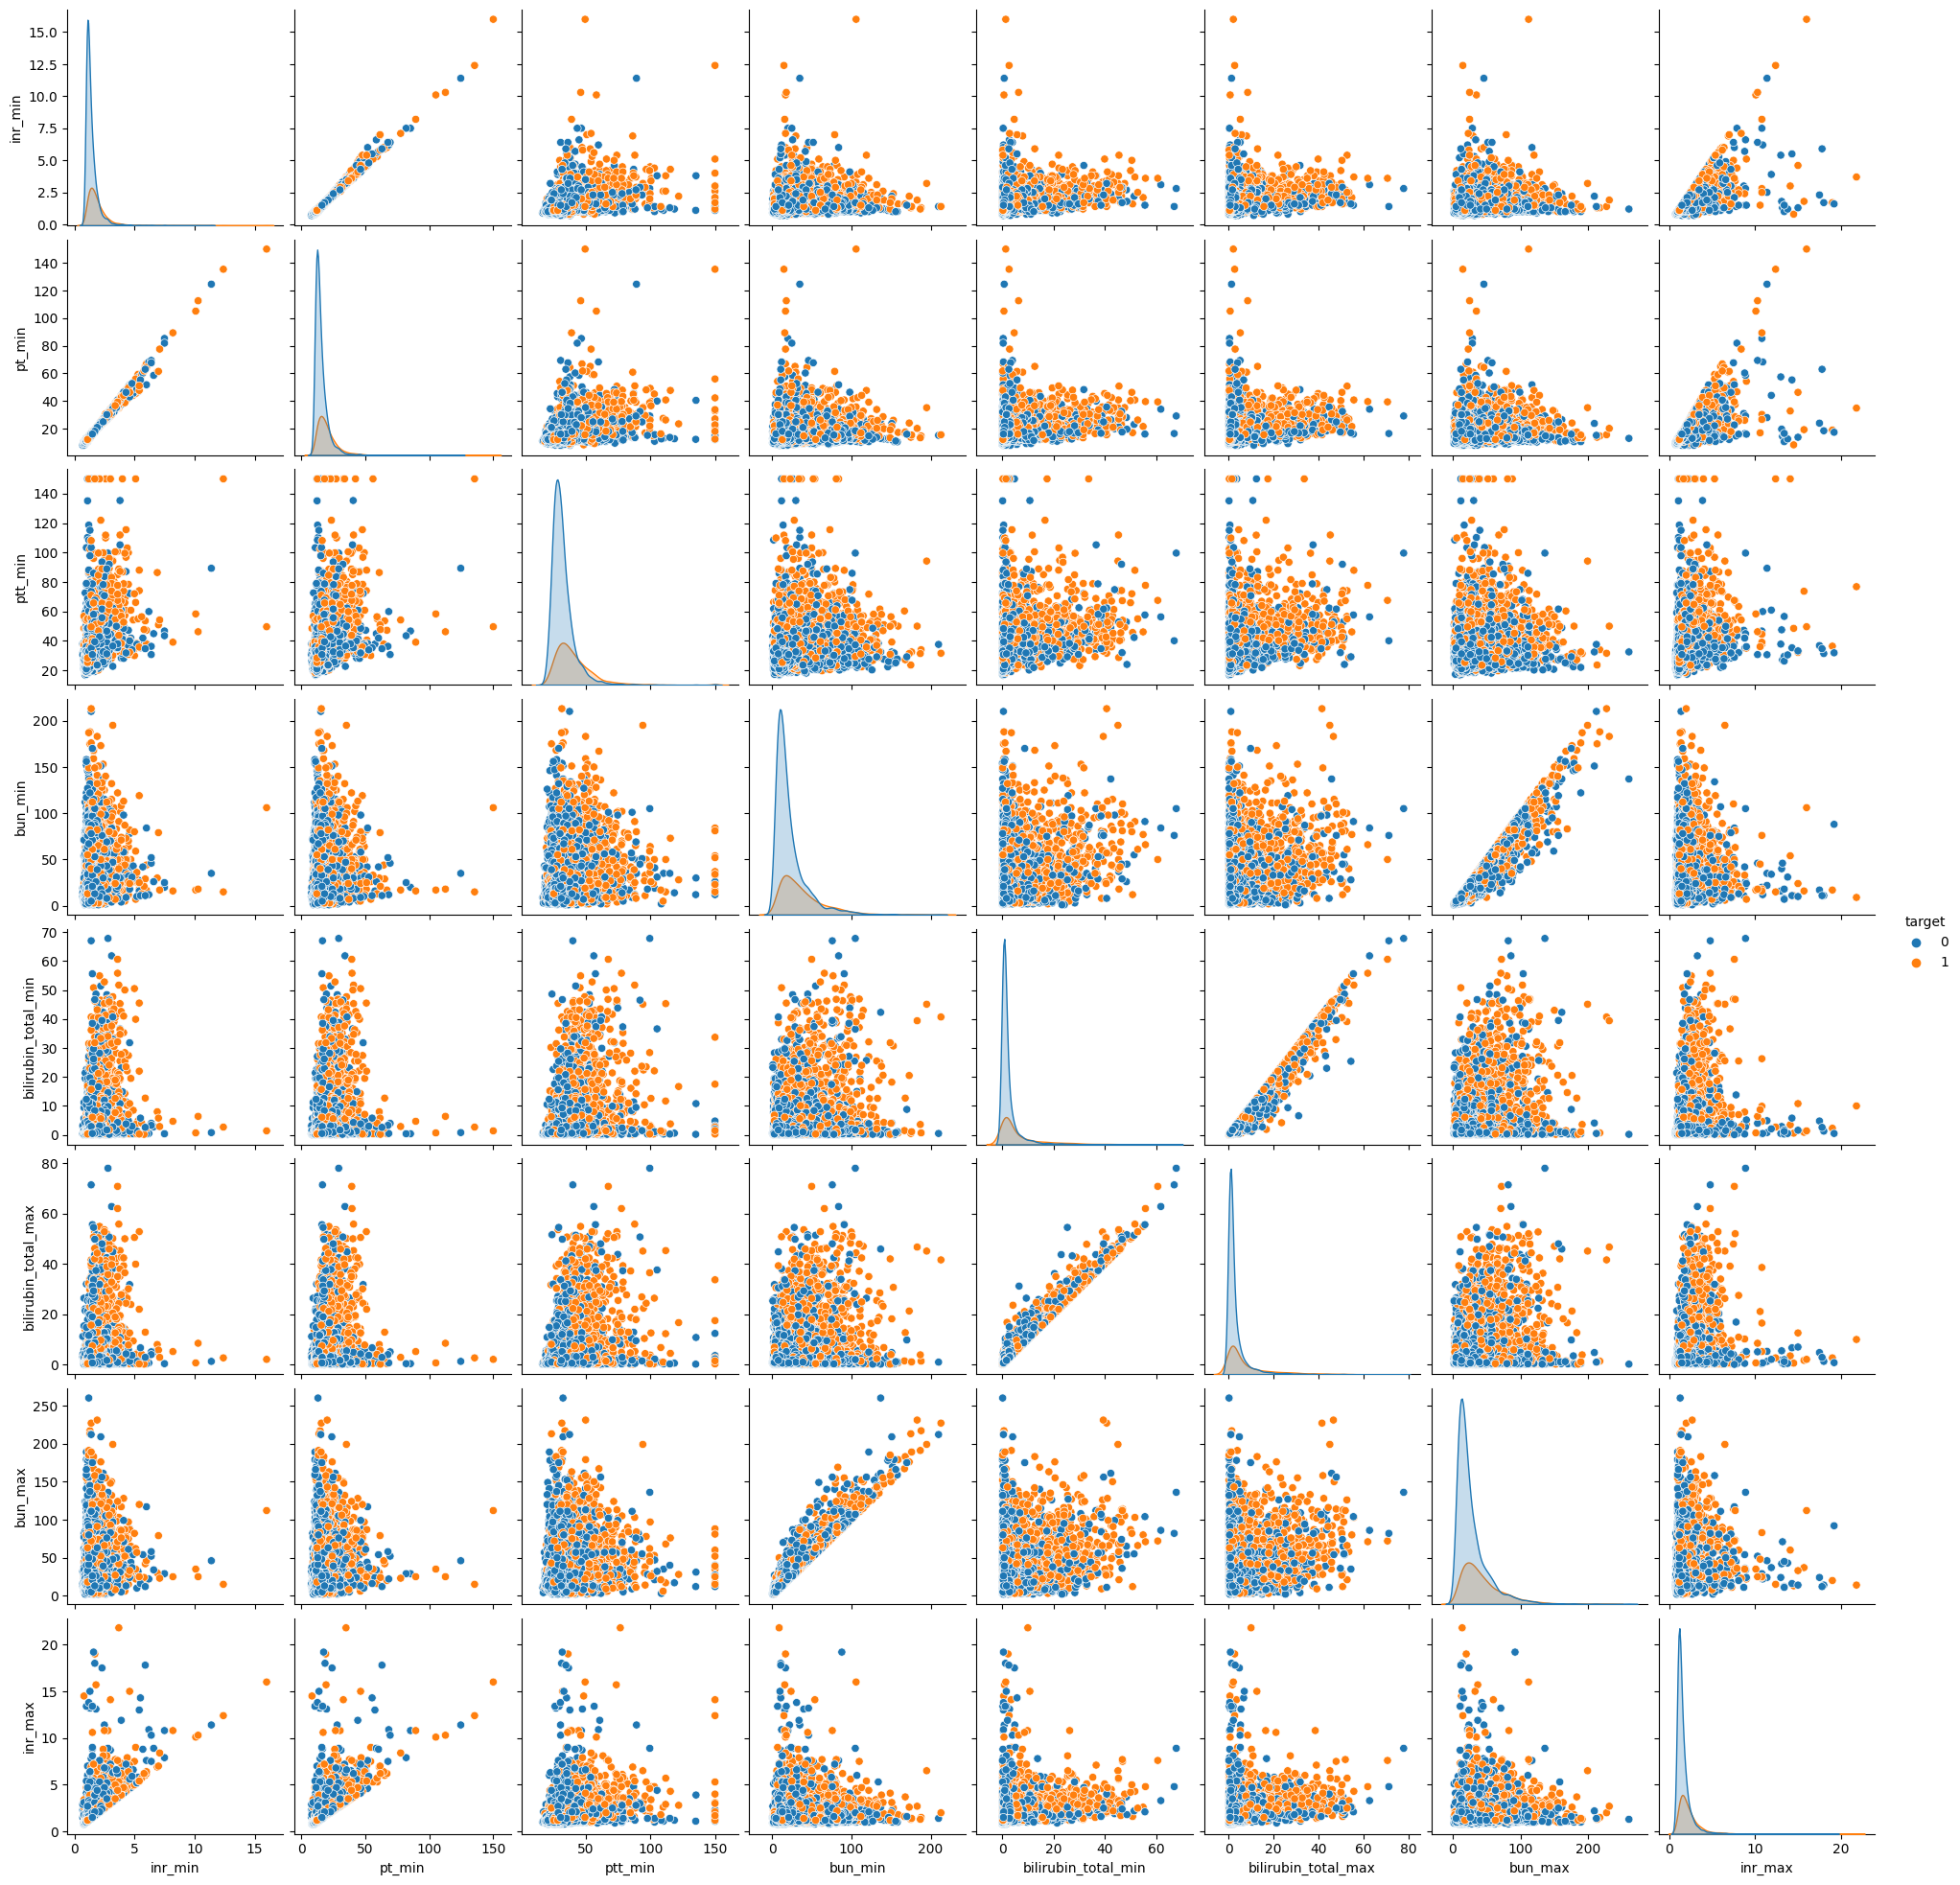

In [13]:
# Plot the relationships betwen variables
sns.pairplot(pairwise_data, hue='target');

**Observations**
- There are some linear relationships:
 - pt_min & inr_min
 - bun_min & bun_max
 - bilirubin_total_min & bilirubin_total_max
- most of the relationships are fairly non-linear

Next let's check for outliers

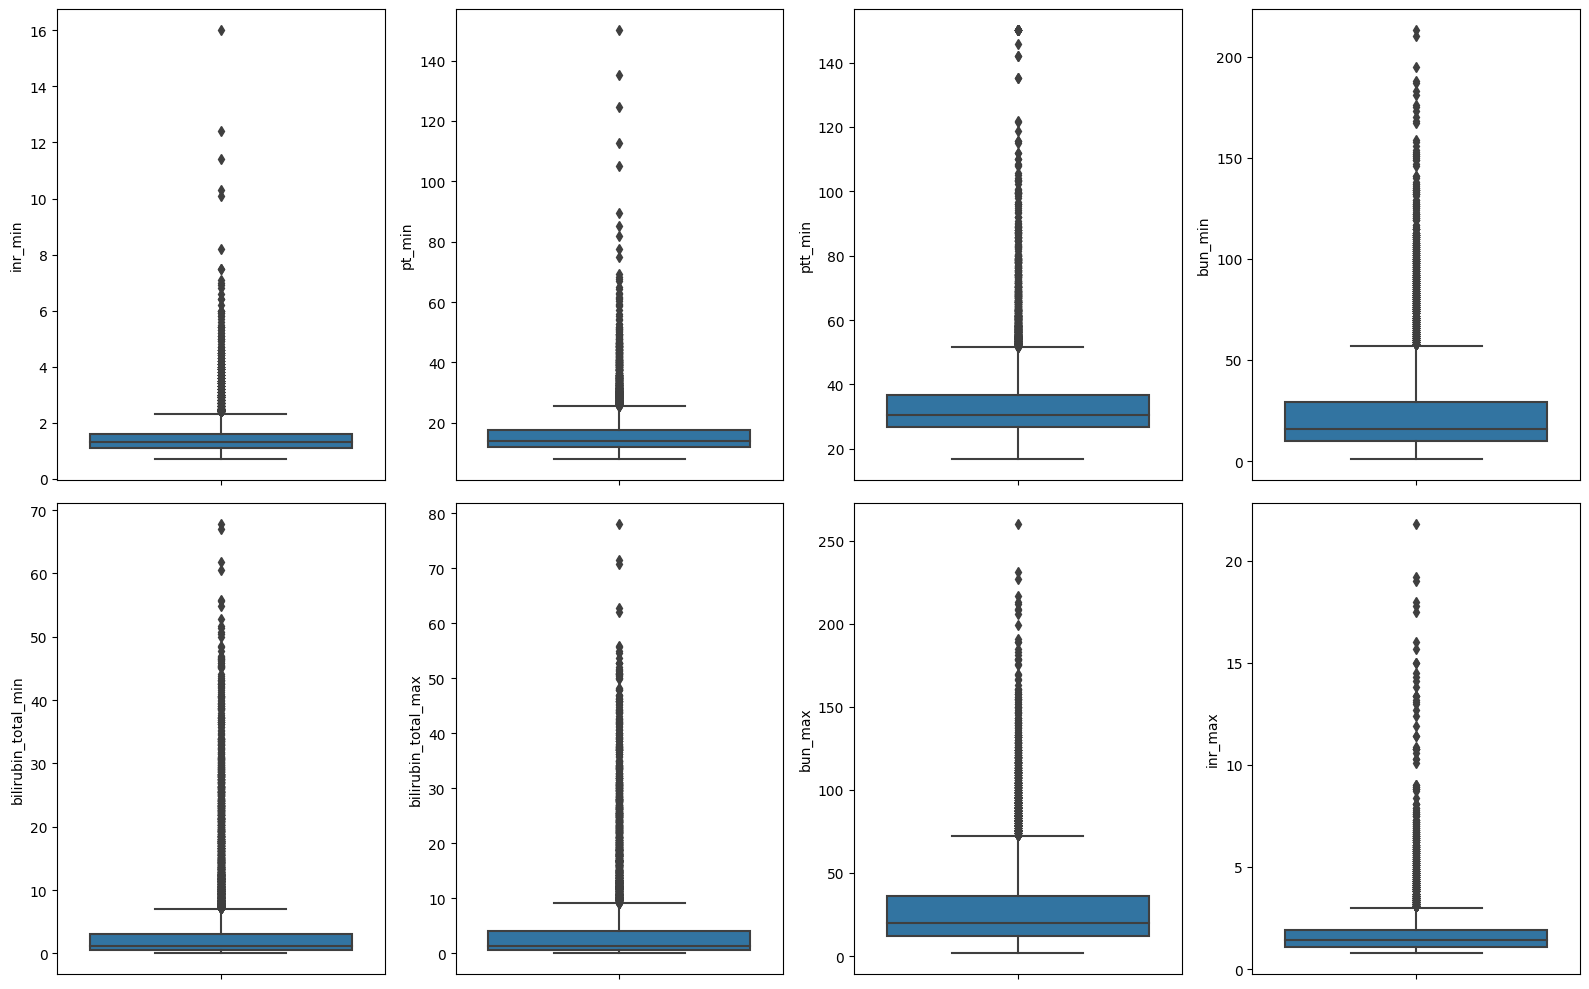

In [14]:
plt.figure(figsize=(16,10))
for i,col in enumerate(key_cols):
    plt.subplot(2,4,i + 1)
    sns.boxplot(y=col, data=df_clean[key_cols])

plt.tight_layout()

plt.show()

**Observations**
- There are a significant number of outliers in all categories

## Categorical variables
Todo:
- Examine gender breakdown
- Examine race breakdown

In [15]:
cat_cols = df_clean.select_dtypes(object)
cat_cols['target'] = df_clean['target']
cat_cols.columns

Index(['race', 'gender', 'target'], dtype='object')

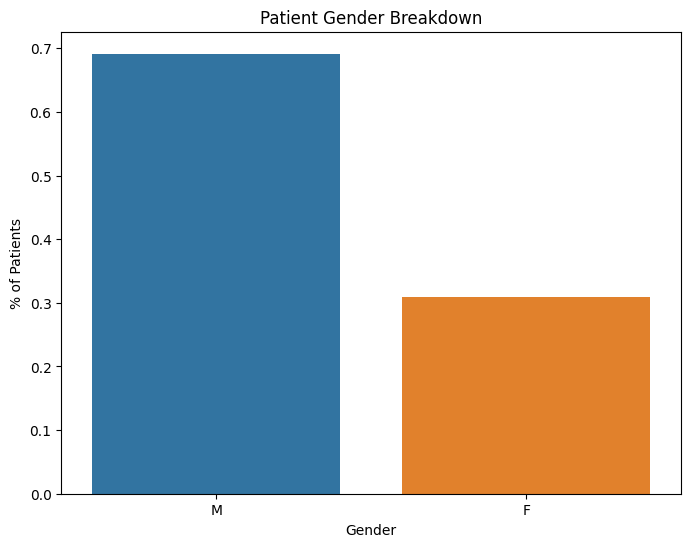

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
race_breakdown = cat_cols['gender'].value_counts(normalize=True).reset_index()
sns.barplot(race_breakdown, x='index', y='gender')

ax.set_title('Patient Gender Breakdown')
ax.set_xlabel('Gender')
ax.set_ylabel('% of Patients');

**Observations**
- There are significantly more male patients than female

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
race_breakdown = cat_cols['race'].value_counts(normalize=True).reset_index()
sns.barplot(race_breakdown, x='race', y='index')

ax.set_title('Patient Race Breakdown')
ax.set_xlabel('% of Patients')
ax.set_ylabel('Race');

**Observations**
- The vast majority of the patients are white

## Meld Scores
Todo:
- Investigate MELD scores vs target
- Investigate MELD groups vs. target
- Calculate MELD ROC Curve and C-Statistic

The MIMIC-IV project has [already calculated](https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iv/concepts_postgres/organfailure/meld.sql) MELD scores. We can use these scores to set expectations for model performance

In [18]:
# MELD 3.0 survival chance calculation
def meld_survival_prediction(meld_score):
  return 1-0.946**math.exp(0.17698*meld_score - 3.56)

In [19]:
# Generate MELD groups
def create_meld_groups(meld_score):
  if meld_score <= 9:
    return '≤9'
  elif meld_score <= 19:
    return '10-19'
  elif meld_score <= 29:
    return '20-29'
  elif meld_score <= 39:
    return '30-39'
  else:
    return '≥40'

In [20]:
# Create a dataframe for meld scores
df_meld = df_clean.loc[:,['meld', 'target']]
df_meld['meld_group'] = df_meld.loc[:,'meld'].apply(create_meld_groups)
df_meld['target_pred'] = df_meld.loc[:,'meld'].apply(meld_survival_prediction)

In [21]:
df_meld.head()

meld  target meld_group  target_pred
0   6.0       0         ≤9     0.004555
1  16.0       1      10-19     0.026441
2  40.0       1        ≥40     0.846486
3  29.0       1      20-29     0.234692
4  11.0       1      10-19     0.011000

First I will take a look at MELD score vs. target

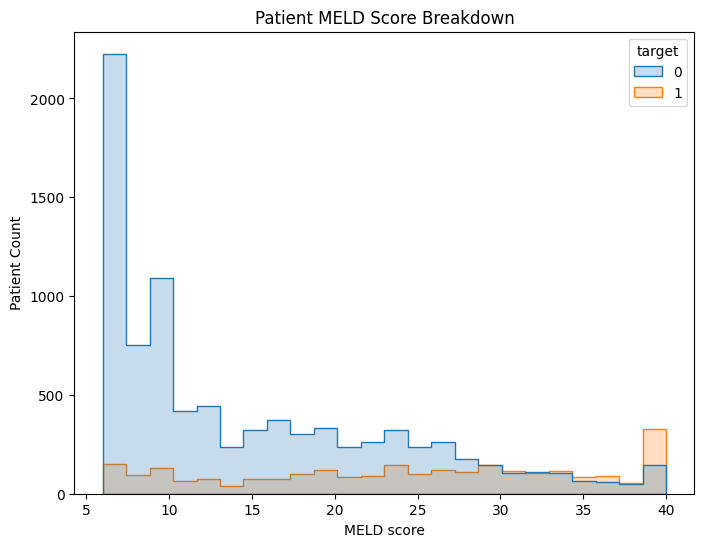

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(df_meld, x='meld', hue='target', element='step')

ax.set_title('Patient MELD Score Breakdown')
ax.set_xlabel('MELD score')
ax.set_ylabel('Patient Count');

**Observations**
- Higher meld scores definitely have more patients who died within 90 days
- There are a significant number of patients with low MELD scores who died within 90 days

In [124]:
fig, ax = plt.subplots(figsize=(8,6))
meld_groups = df_meld.groupby(['meld_group', 'target']).count().reset_index()
order=['≤9', '10-19', '20-29', '30-39', '≥40']
sns.barplot(meld_groups, x='meld_group', y='target_pred', hue='target', order=order)

ax.set_title('Patient MELD Groups')
ax.set_xlabel('MELD Group')
ax.set_ylabel('Patient Count');

**Observations**
- A significant number of patients died from all categories except ≤9
- A significant number of patients survived at higher MELD scores

In [25]:
# Generate ROC curve from predictions
RocCurveDisplay.from_predictions(df_meld['target'],df_meld['target_pred'], pos_label=1);

Ok! So for this population MELD scores have a C-statistic of 0.76. This will be the bar to aim for.

# Helper Functions
I will be creating two helper functions, stolen from earlier projects of mine. The first will be to store models and compare model to model. The second will be to score the model itself

In [26]:
class ModelStorer():
  """
  Helper function to store model and print out results.

  Attributes:
  -models: a dictionary used to store models
  -model_scores: all model scores
  -model_cv_results: all model cross validation results

  Methods:
  - add_model(model): add a model to the dictionary
  - validate_models(): validate the models on the whole dataset
  - print_scores(metric='accuracy_score'): print all models' scores for selected metric
  - return_scores(): get all the models scores
  - plot_models_roc_curves(dataset='train'): plot models ROC curves for selected dataset
  - plot_models_scores(dataset='train'): Plot models scores for selected dataset
  - show_cv_results(): shows the models cv results in a table
  - plot_models_confusion_matricies(): plot confusion matricies for all models
  """

  def __init__(self):
    self.models = {} # model dictionary
    self.model_scores = pd.DataFrame(columns=['model', 'dataset', 'metric', 'value']) # df for model scores
    self.model_cv_results = pd.DataFrame(columns=['model', 'CV Results']) # df for model cross validation results

  # Add a model to the models dictionary for storage
  def add_model(self, model):
    """Add a SaveModel object to the model dictionary"""
    self.models[model.model_name] = model
    self.model_scores = self.model_scores.append(model.model_scores)
    self.model_cv_results = self.model_cv_results.append(model.cv_summary)

  def validate_models(self):
    """Validate all the saved models"""
    for name, model in self.models.items():
        model.score_model_validate()

        model_data = model.model_scores
        val_filter = model_data['dataset']=='validate'
        self.model_scores = self.model_scores.append(model_data[val_filter])

  def print_scores(self, metric='accuracy_score'):
    """Print scores and filter to input metric"""
    display(self.model_scores[ self.model_scores['metric'] == metric])

  def return_scores(self):
    """Get all the models scores"""
    return self.model_scores

  def plot_models_roc_curves(self, dataset='train'):
    """Plot ROC curves for all models, input desired dataset"""
    fig, ax = plt.subplots(figsize=(6,6))
    for name, model in self.models.items():
        model.plot_model_roc_curve(ax, dataset) # call SaveModel function
    fig.suptitle(f'Model ROC Curves for {dataset.title()} Data')
    plt.show()

  def plot_models_scores(self, dataset='train'):
    """Plot model scores based on input dataset"""
    data = self.model_scores
    # FacetGrid will plot multiple metrics in the same figure
    g = sns.FacetGrid(data[data['dataset']==dataset], col="metric", col_wrap=2, height=4)
    g.map(sns.barplot, "value", "model", order=list(self.models.keys()))
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Model Metrics for {dataset.title()} Data')

  def show_cv_results(self):
    """Show the cross validation results"""
    display(self.model_cv_results)

  def plot_models_confusion_matricies(self, dataset='train'):
    """Plot the models confustion matricies based on input dataset"""
    num_models = len(self.models.keys())

    nrows = 2
    ncols = math.ceil(num_models/nrows)

    fig, axes = plt.subplots(
                    nrows=nrows,
                    ncols=ncols,
                    figsize=(ncols*3, nrows*3)
    )
    fig.suptitle(f'Model Confusion Matricies for {dataset.title()} Data')

    # Turn off all the axes in case there is nothing to plot
    [ax.axis('off') for ax in axes.ravel()]


    for i, (name, model) in enumerate(self.models.items()):
        # Logic for making rows and columns for matrices
        row = i // ncols
        col = i % ncols
        ax = axes[row, col]
        ax.set_title(name)
        ax.set_axis_on() # turn back on the axis
        model.plot_model_confusion_matrix(ax, dataset)

    plt.tight_layout()

In [2]:
class SaveModel():
  """
  Helper function to store a single model

  Attributes:
  - Data splits: X & y train, test, train_test (both train & test), and validation sets
  - model: the model itself
  - model_name: a custom model name

  Methods:
  - score_model_train_test(): fits the model and calculates scores for train and test data
  - score_model_validate(): validates the model and scores it on validaiton data
  - plot_model_roc_curve(ax, dataset='train'): plots a single ROC curve for the model
  - plot_model_confusion_matrix(ax, dataset='train'): plots a single confusion matrix for the model
  """
  def __init__(self,
               model,
               X_train,
               y_train,
               X_train_test,
               y_train_test,
               X_test,
               y_test,
               X_val,
               y_val,
               model_name='None'):
    self.model = model
    self.model_name = model_name
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test
    self.X_train_test = X_train_test
    self.y_train_test = y_train_test
    self.X_val = X_val
    self.y_val = y_val

  def info(self):
    print(f'-------{self.model_name} Information-------')
    print(f'Model: {self.model}')

  def score_model_train_test(self):
    """Fit model on train data and score it (cv included)"""
    # Fit on training data
    self.model.fit(self.X_train, self.y_train)

    # Predict on training and test data
    self.ytrain_hat = self.model.predict(self.X_train)
    self.ytrain_prob = self.model.predict_proba(self.X_train)
    self.ytest_hat = self.model.predict(self.X_test)
    self.ytest_prob = self.model.predict_proba(self.X_test)

    # cross validation
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    self.cv_results = cross_val_score(self.model, self.X_train, y_train, cv=kf)
    self.cv_mean = np.mean(self.cv_results)
    self.cv_median = np.median(self.cv_results)
    self.cv_std = np.std(self.cv_results)
    cv_sum = f'{self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy'
    self.cv_summary = pd.DataFrame([[self.model_name, cv_sum]], columns=['model', 'CV Results'])


    # Create the model scores on train and test data
    self.model_scores = pd.DataFrame([
                    [self.model_name, 'train', 'accuracy_score', accuracy_score(self.y_train, self.ytrain_hat)],
                    [self.model_name, 'train', 'recall_score', recall_score(self.y_train, self.ytrain_hat)],
                    [self.model_name, 'train', 'precision_score', precision_score(self.y_train, self.ytrain_hat)],
                    [self.model_name, 'train', 'f1_score', f1_score(self.y_train, self.ytrain_hat)],
                    [self.model_name, 'test', 'accuracy_score', accuracy_score(self.y_test, self.ytest_hat)],
                    [self.model_name, 'test', 'recall_score', recall_score(self.y_test, self.ytest_hat)],
                    [self.model_name, 'test', 'precision_score', precision_score(self.y_test, self.ytest_hat)],
                    [self.model_name, 'test', 'f1_score', f1_score(self.y_test, self.ytest_hat)]
                    ],
                    columns=['model', 'dataset', 'metric', 'value'])

  def score_model_validate(self):
    """Fit model on train and test data and score on validation set"""
    # Train on the full dataset
    self.model.fit(self.X_train_test, self.y_train_test)

    # Predict results for the validate dataset
    self.yval_hat = self.model.predict(self.X_val)
    self.yval_prob = self.model.predict_proba(self.X_val)

    # Add the scores to the model scores
    self.model_scores = self.model_scores.append(
          pd.DataFrame([
                    [self.model_name, 'validate', 'accuracy_score', accuracy_score(self.y_val, self.yval_hat)],
                    [self.model_name, 'validate', 'recall_score', recall_score(self.y_val, self.yval_hat)],
                    [self.model_name, 'validate', 'precision_score', precision_score(self.y_val, self.yval_hat)],
                    [self.model_name, 'validate', 'f1_score', f1_score(self.y_val, self.yval_hat)],
                    ],
                    columns=['model', 'dataset', 'metric', 'value'])
    )

  def get_data(self, dataset, data_type):
    if dataset == 'train':
          y = list(self.y_train)
          y_hat = self.ytrain_hat if data_type == 'pred' else self.ytrain_prob[:,1]
    elif dataset == 'test':
          y = list(self.y_test)
          y_hat = self.ytest_hat if data_type == 'pred' else self.ytest_prob[:,1]
    elif dataset == 'validate':
          y = list(self.y_val)
          y_hat = self.yval_hat if data_type == 'pred' else self.yval_prob[:,1]

    return y, y_hat

  def plot_model_roc_curve(self, ax, dataset='train'):
    """Plot the model's ROC curve"""
    # Get data
    (y, y_hat) = self.get_data(dataset, 'proba')

    # Plot the model's ROC curve from stored predictions
    RocCurveDisplay.from_predictions(y, y_hat, ax=ax, name=self.model_name)

  def plot_model_confusion_matrix(self, ax, dataset='train'):
    """Plot the model's confusion matrix"""

    # Get the data
    (y, y_hat) = self.get_data(dataset, 'pred')

    # Plot the model's confusion matrix from predictions
    cm_display = ConfusionMatrixDisplay.from_predictions(y,
                                        y_hat,
                                        normalize='true',
                                        cmap='plasma',
                                        display_labels=['Survived', 'Perished'],
                                        ax=ax)
    cm_display.im_.set_clim(0, 1)

# Modeling

In [28]:
def train_test_val_split(X,y):
  """Splits data into train, test, and validation sets and print out results"""
  X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, random_state=42)
  X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, random_state=42)
  print('----------X Information----------')
  print(f'shape X_train = {X_train.shape}')
  print(f'shape X_test = {X_test.shape}')
  print(f'shape X_train_test = {X_train_test.shape}')
  print(f'shape X_val = {X_val.shape}')
  print('----------y Information----------')
  print('y_train value counts')
  print(y_train.value_counts())
  print('--------------------')
  print('y_test value counts')
  print(y_test.value_counts())
  print('--------------------')
  print('y_train_test value counts')
  print(y_train_test.value_counts())
  print('--------------------')
  print('y_val value counts')
  print(y_val.value_counts())
  return X_train, X_test, X_train_test, X_val, y_train, y_test, y_train_test, y_val


In [29]:
# Split up our data into train, test, and validation sets
X = df_clean.drop(['target', 'meld'], axis=1)
y = df_clean['target']
X_train, X_test, X_train_test, X_val, y_train, y_test, y_train_test, y_val = train_test_val_split(X, y)

----------X Information----------
shape X_train = (6401, 53)
shape X_test = (2134, 53)
shape X_train_test = (8535, 53)
shape X_val = (2846, 53)
----------y Information----------
y_train value counts
0    4915
1    1486
Name: target, dtype: int64
--------------------
y_test value counts
0    1660
1     474
Name: target, dtype: int64
--------------------
y_train_test value counts
0    6575
1    1960
Name: target, dtype: int64
--------------------
y_val value counts
0    2191
1     655
Name: target, dtype: int64


In [30]:
# Instantiate our model storage
model_dict = ModelStorer()

## Dummy Model & Baseline Models
The dummy model will be a DummyClassifier, I'll also use a logistic regression and decision tree classifier.

In [31]:
# Create the subpipe for the numeric variables
subpipe_numerics = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

In [32]:
# Create the column transformer
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))
], remainder='passthrough')

In [33]:
# Create some baseline models
dum_model = DummyClassifier(strategy='most_frequent')
lr_model = LogisticRegression()
tree_model = DecisionTreeClassifier()
model_list = [('dummy',dum_model), ('logreg',lr_model), ('dtc',tree_model)]

dummy_models = {}

for name, model in model_list:

    # Create baseline pipelines
    loop_model_pipe = ImPipeline(steps=[
        ('ct', CT),
        ('sm',SMOTE(random_state=42)),
        (name, model)
    ])

    # Create a saved model object
    loop_model_results = SaveModel(
        model=loop_model_pipe,
        model_name=name,
        X_train=X_train,
        y_train=y_train,
        X_train_test=X_train_test,
        y_train_test=y_train_test,
        X_test=X_test,
        y_test=y_test,
        X_val=X_val,
        y_val=y_val,
        )

    # Fit and score on train and test data
    loop_model_results.score_model_train_test()

    # Add the model to the dictionary
    model_dict.add_model(loop_model_results)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-26-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-26-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_

Now I will look at the ROC curves for train and test

In [35]:
model_dict.plot_models_roc_curves('train')

In [36]:
model_dict.plot_models_roc_curves('test')

**Observations**
- The decision tree is very overfit
- The logistic regression is performing very well
- Both beat out the dummy classifier which means I'm successfully picking up signal in the data

In [39]:
model_dict.show_cv_results()

model                  CV Results
0   dummy  0.76785 ± 0.00991 accuracy
0  logreg  0.75332 ± 0.01661 accuracy
0     dtc  0.72536 ± 0.01128 accuracy

**Observations**

The dummy model performed better in cross validaiton scores than the logistic regression or decision tree, this may mean I should introduce a different algorythm.

Now it's time to try some others, coming up are XGBoost, KNN, and Neural network along with some dimention reduction and feature engineering via clustering

## XGBoost
"XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable."
[xgboost](https://xgboost.readthedocs.io/en/stable/)

The highly efficient aspect makes it appealing for projects like this where I don't want to spend weeks training a neural network

In [41]:
# Create a classifier with objective='binary:logistic' for this binary classification problem
grad_boost = XGBClassifier(random_state=42, objective='binary:logistic')

# Create pipelines
xgb_pipe = ImPipeline(steps=[
    ('ct', CT), # start by using the same column transformer
    ('sm',SMOTE(random_state=42)), # handle class imbalance using SMOTE
    ('xgb', grad_boost)
])

# Create a saved model object
xgb_pipe_results = SaveModel(
    model=xgb_pipe,
    model_name='xgb',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_pipe_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(xgb_pipe_results)

<ipython-input-26-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-26-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


In [42]:
model_dict.plot_models_roc_curves('test')

In [43]:
model_dict.show_cv_results()

model                  CV Results
0   dummy  0.76785 ± 0.00991 accuracy
0  logreg  0.75332 ± 0.01661 accuracy
0     dtc  0.72536 ± 0.01128 accuracy
0     xgb  0.81331 ± 0.00668 accuracy

**Observations**

While performing similarly to logistic regression on the ROC curve, XGBoost outperformed all models on the CV results suggesting it will perform better on unseen data.

## Reducing Dimmensionality
Part of the challenge with this project is that currently I have 54 features. MELD has 5 which makes it feasible for an online calculator. I'm going to try and reduce dimensionality without sacrificing too much accuracy.

### Select From Model
Let's start by using [Select From Model](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) which selects top features based on importance. I'll also use XGBoost for feature importance since it was proven to perform well.

In [44]:
grad_boost_sfm = XGBClassifier(random_state=42, objective='binary:logistic')

# Create the subpipe for the numeric variables
subpipe_numerics_sfm = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler()),
    ('sfm',SelectFromModel(XGBClassifier(random_state=42, objective='binary:logistic'), max_features=10))
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat_sfm = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

# Create the column transformer
CT_SFM = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics_sfm, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat_sfm, selector(dtype_include=object))
], remainder='passthrough')

xgb_sfm_pipe = ImPipeline(steps=[
        ('ct', CT_SFM),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_sfm)
    ])

# Create a saved model object
xgb_sfm_results = SaveModel(
    model=xgb_sfm_pipe,
    model_name='XGB_SFM',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_sfm_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(xgb_sfm_results)

<ipython-input-26-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-26-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


In [45]:
model_dict.plot_models_roc_curves('test')

In [47]:
model_dict.show_cv_results()

model                  CV Results
0    dummy  0.76785 ± 0.00991 accuracy
0   logreg  0.75332 ± 0.01661 accuracy
0      dtc  0.72536 ± 0.01128 accuracy
0      xgb  0.81331 ± 0.00668 accuracy
0  XGB_SFM  0.80472 ± 0.01418 accuracy

**Observations**
Using Select from Model dropped the C-statistic from 0.84 to 0.81 on test data and the CV results from 0.81 to 0.80. That's fairly acceptable for reducing from 54 features to 10 features.

Now I will check out the importand features

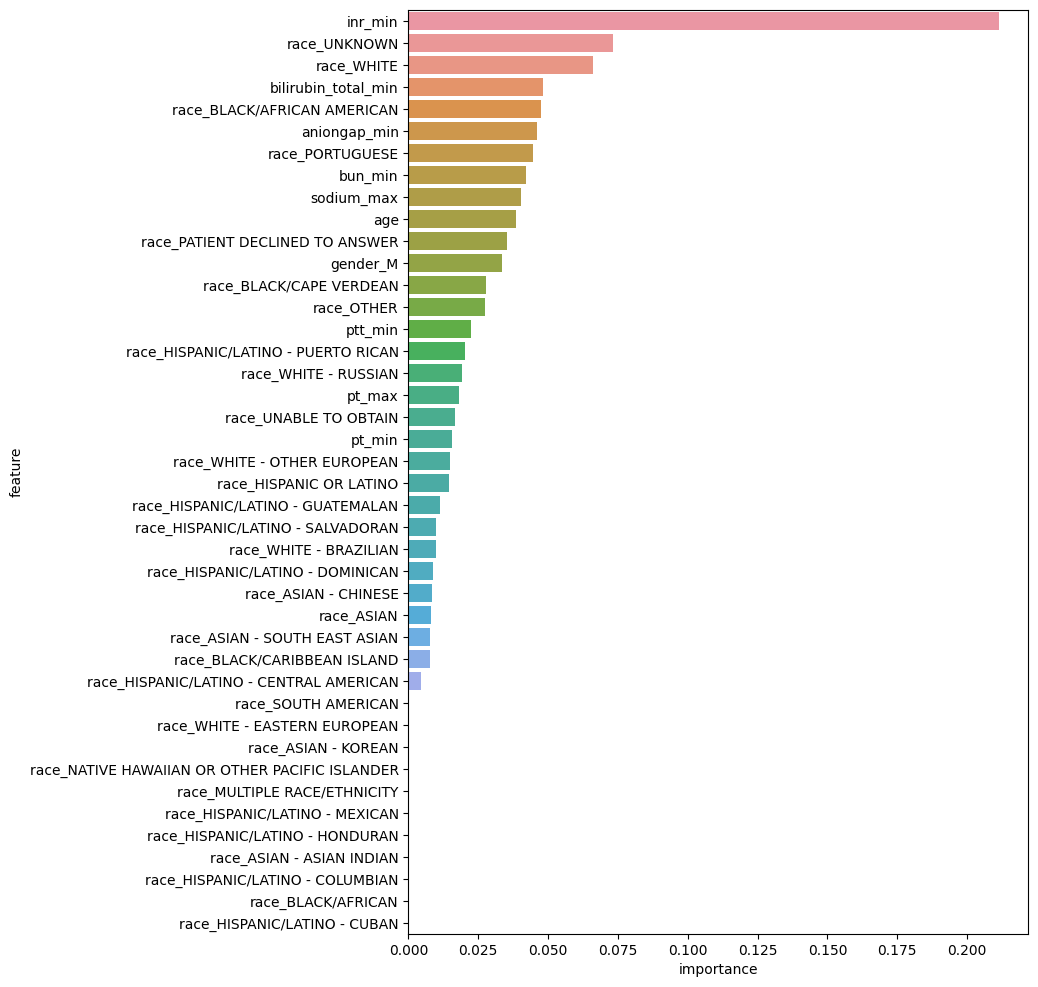

In [46]:
xgb_features = pd.DataFrame()

y = model_dict.models['XGB_SFM'].model.named_steps.ct.get_feature_names_out()
xgb_features['feature'] = [val.split("__")[1] for val in y]

xgb_features['importance'] = pd.DataFrame(model_dict.models['XGB_SFM'].model.named_steps.xgb.feature_importances_).astype(float)[0]

xgb_features = xgb_features.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(data=xgb_features, y='feature', x='importance', ax=ax);

**Observations**
- Race seems to be a significant factor
- I'm surprised to see Age on there because it's not included in MELD
- Some of these features don't align with MELD scores which makes me think there are some errors in my model.

Bilirubin, INR, and Albumin are there but I don't see creatine or Sodium.

### Principal Component Analysis
Another method of reducing dimensionality is [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA). "Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space."

In [48]:
## PCA
grad_boost_pca = XGBClassifier(random_state=42, objective='binary:logistic')

xgb_pca_pipe = ImPipeline(steps=[
        ('ct', CT),
        ('pca', PCA(n_components=10)), # I'll also keep it at 10 components
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_pca)
    ])

# Create a saved model object
xgb_pca_results = SaveModel(
    model=xgb_pca_pipe,
    model_name='XGB_PCA',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_pca_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(xgb_pca_results)

<ipython-input-26-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-26-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


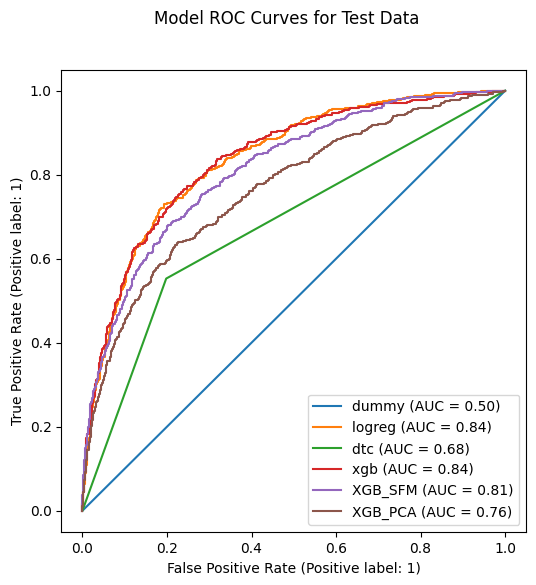

In [49]:
model_dict.plot_models_roc_curves('test')

In [50]:
model_dict.show_cv_results()

model                  CV Results
0    dummy  0.76785 ± 0.00991 accuracy
0   logreg  0.75332 ± 0.01661 accuracy
0      dtc  0.72536 ± 0.01128 accuracy
0      xgb  0.81331 ± 0.00668 accuracy
0  XGB_SFM  0.80472 ± 0.01418 accuracy
0  XGB_PCA  0.75879 ± 0.01146 accuracy

**Observations**

PCA performed worse than using SFM, this is likely not the way forward.

## Outlier Handling
I want to see if outliers are causing problems with the model. To do this I will create a custom transformer using [IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest), which returns an anomoly score for every sample. Samples that have too high of a score will be removed.

I will also use Select From Model here since that performed well

In [51]:
grad_boost_outlier = XGBClassifier(random_state=42, objective='binary:logistic')

# Create the subpipe for the numeric variables
subpipe_numerics_out = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler()),
    ('sfm',SelectFromModel(XGBClassifier(random_state=42, objective='binary:logistic'), max_features=10))
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat_out = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

# Create the column transformer
CT_OUT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics_out, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat_out, selector(dtype_include=object))
], remainder='passthrough')

# Create the outlier handler
outlier_detector = IsolationForest(random_state = 42)
enricher = FeatureUnion([
  ("identity", IdentityTransformer()),
  ("outlier_detector", EstimatorTransformer(outlier_detector, predict_func = "decision_function"))
])

xgb_out_pipe = ImPipeline(steps=[
        ('ct', CT_OUT),
        ("enricher", enricher),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_outlier)
    ])

# Create a saved model object
xgb_out_results = SaveModel(
    model=xgb_out_pipe,
    model_name='XGB_OUT',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_out_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(xgb_out_results)

<ipython-input-26-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-26-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


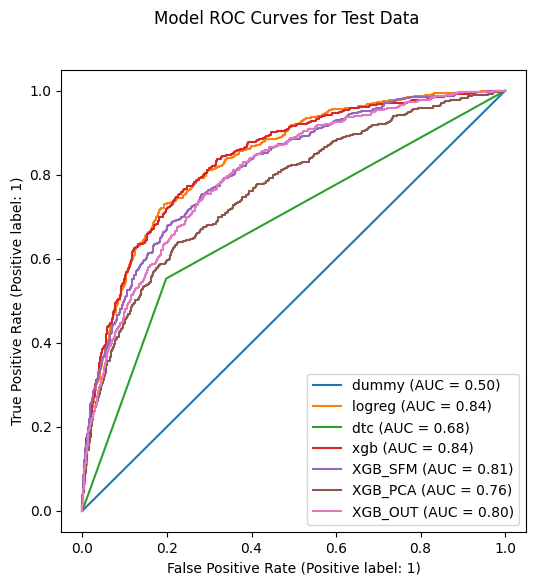

In [54]:
model_dict.plot_models_roc_curves('test')

In [52]:
model_dict.show_cv_results()

model                  CV Results
0    dummy  0.76785 ± 0.00991 accuracy
0   logreg  0.75332 ± 0.01661 accuracy
0      dtc  0.72536 ± 0.01128 accuracy
0      xgb  0.81331 ± 0.00668 accuracy
0  XGB_SFM  0.80472 ± 0.01418 accuracy
0  XGB_PCA  0.75879 ± 0.01146 accuracy
0  XGB_OUT  0.80550 ± 0.01111 accuracy

**Observations**
The outlier model performed marginally better than Select From Model on the CV score but worse on the ROC score for test.

## KNN
Another model I will try is [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). An sklearn implementation of the k-nearest neighbors voting. I'll have to find the optimal value of K before creating the model

In [55]:
k_scores_train = {}
k_scores_test = {}

# Train models with various values of K and store results
for k in range(1, 40):
  knn = KNeighborsClassifier(n_neighbors=k)

  knn_pipe = ImPipeline(steps=[
        ('ct', CT3),
        ("enricher", enricher),
        ('sm',SMOTE(random_state=42)),
        ('knn',knn)
    ])

  knn_pipe.fit(X_train, y_train)

  y_pred_train = knn_pipe.predict(X_train)
  y_pred_test = knn_pipe.predict(X_test)

  k_scores_train[k] = accuracy_score(y_train, y_pred_train)
  k_scores_test[k] = accuracy_score(y_test, y_pred_test)

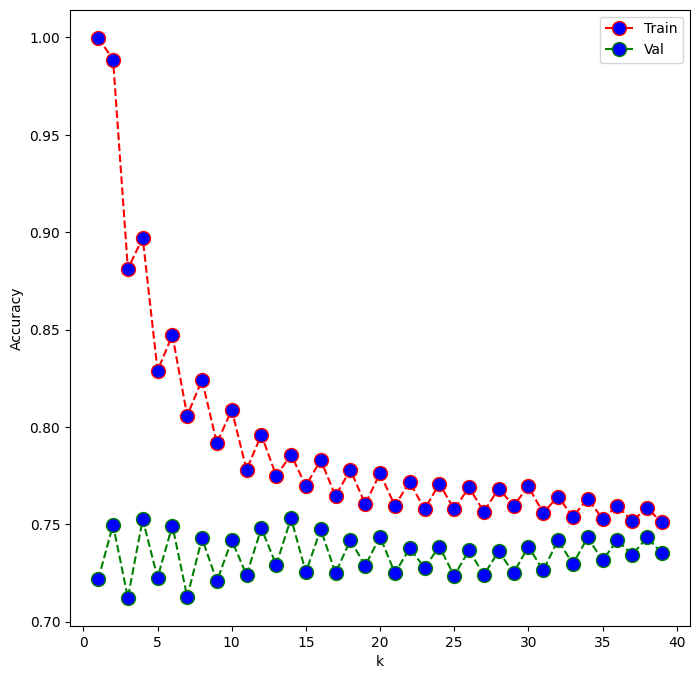

In [56]:
# Plot accuracy of train and test datasets
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(list(k_scores_train.keys()), list(k_scores_train.values()),
        color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Train')
ax.plot(list(k_scores_test.keys()), list(k_scores_test.values()),
        color='green', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Test')
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
plt.legend();

**Observations**
The best accuracy is when K=14

Now it's time to create the pipeline and save the model

In [57]:
knn_final = KNeighborsClassifier(n_neighbors=14)

knn_pipe_final = ImPipeline(steps=[
      ('ct', CT_OUT),
      ("enricher", enricher),
      ('sm',SMOTE(random_state=42)),
      ('knn',knn_final)
  ])

# Create a saved model object
knn_results = SaveModel(
    model=knn_pipe_final,
    model_name='KNN',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
knn_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(knn_results)

<ipython-input-26-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-26-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


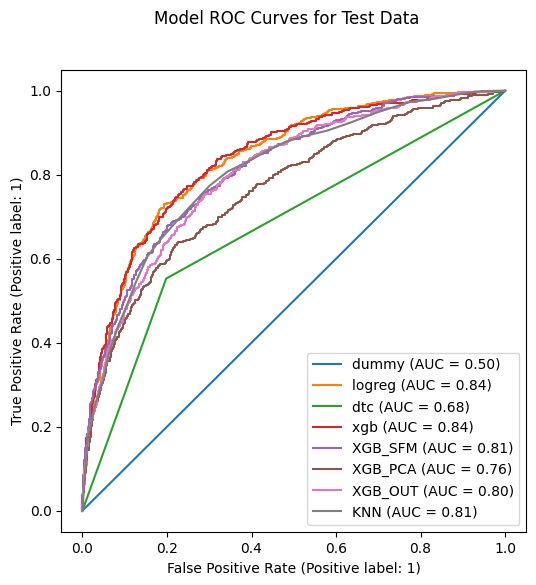

In [58]:
model_dict.plot_models_roc_curves('test')

In [59]:
model_dict.show_cv_results()

model                  CV Results
0    dummy  0.76785 ± 0.00991 accuracy
0   logreg  0.75332 ± 0.01661 accuracy
0      dtc  0.72536 ± 0.01128 accuracy
0      xgb  0.81331 ± 0.00668 accuracy
0  XGB_SFM  0.80472 ± 0.01418 accuracy
0  XGB_PCA  0.75879 ± 0.01146 accuracy
0  XGB_OUT  0.80550 ± 0.01111 accuracy
0      KNN  0.71474 ± 0.01439 accuracy

**Observations**

KNN performed worse than other options, it's not likely that this will be our final model

## Polynomial Features
Since the MELD score using polynomial features I want to try it as well
> MELD 3.0 = 1.33*(Female) + 4.56*ln(Serum bilirubin) + 0.82*(137 - Sodium) – 0.24*(137 - Sodium)*ln(Serum bilirubin) + 9.09*ln(INR) + 11.14*ln(Serum creatinine) + 1.85*(3.5 – Serum albumin) – 1.83*(3.5 – Serum albumin)*ln(Serum creatinine) + 6

In [60]:
grad_boost_poly = XGBClassifier(random_state=42, objective='binary:logistic', nthread=-1)

# Create the subpipe for the numeric variables
subpipe_numerics_poly = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('sfm',SelectFromModel(XGBClassifier(random_state=42, objective='binary:logistic', nthread=-1), max_features=10))
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat_poly = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

# Create the column transformer
CT_POLY = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics_poly, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat_poly, selector(dtype_include=object))
], remainder='passthrough')

xgb_poly_pipe = ImPipeline(steps=[
        ('ct', CT_POLY),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_poly)
    ])

# Create a saved model object
xgb_poly_results = SaveModel(
    model=xgb_poly_pipe,
    model_name='XGB_POLY',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_poly_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(xgb_poly_results)

<ipython-input-26-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-26-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


In [61]:
model_dict.show_cv_results()

model                  CV Results
0     dummy  0.76785 ± 0.00991 accuracy
0    logreg  0.75332 ± 0.01661 accuracy
0       dtc  0.72536 ± 0.01128 accuracy
0       xgb  0.81331 ± 0.00668 accuracy
0   XGB_SFM  0.80472 ± 0.01418 accuracy
0   XGB_PCA  0.75879 ± 0.01146 accuracy
0   XGB_OUT  0.80550 ± 0.01111 accuracy
0       KNN  0.71474 ± 0.01439 accuracy
0  XGB_POLY  0.78207 ± 0.01480 accuracy

**Observations**

Polynomial features decreased the accuracy of the model, it's not likely this will be included in the final model

## Clustering
Another approach to improving model scores is by using unsupervised learning to group datapoints. I'll use [Kmeans clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for this project.

First I need to chose the number of clusters, to do that I'll check the silhouette scores for various cluster values. I want to maximize the score so I'll check the highest value.

In [64]:
km_data_scaled = CT_SFM.transform(X_train)
silhouette_scores = []
for j in range(2, 3):
    clusters = KMeans(n_clusters=j, random_state=42, n_init=10)
    cluster_labels = clusters.fit_predict(km_data_scaled)
    silhouette = silhouette_score(km_data_scaled, cluster_labels)
    silhouette_scores.append(silhouette)

In [65]:
print(np.argmax(silhouette_scores))

0


It looks like the best score is n_clusters=2

In order to add Kmeans clustering to a pipeline I have to create a custom sklearn transformer

In [66]:
# Create a custom column selector to add in the clustering
class Kmean_cluster(BaseEstimator, TransformerMixin):
    '''Add in a Kmeans cluster column to the dataset'''

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_df = pd.DataFrame(X)
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(X)
        X_df['kmeans_cluster'] = kmeans
        return np.array(X_df)

## test the Kmean_cluster class
kmeans_cluster = Kmean_cluster()
kmeans_cluster.transform(num_cols.fillna(0))

array([[36. , 32.4, 35.5, ...,  0.5,  0. ,  0. ],
       [55. , 24.5, 26.7, ...,  3.2,  1. ,  0. ],
       [42. , 22.6, 32.5, ..., 20.2,  1. ,  0. ],
       ...,
       [69. , 29.5, 39.1, ...,  0. ,  0. ,  0. ],
       [61. , 45.5, 47.1, ...,  0.7,  0. ,  0. ],
       [65. , 39.4, 43.1, ...,  1.7,  0. ,  0. ]])

Now I will save a new model using clustering and the same column transformer as save from model

In [67]:
grad_boost_clus = XGBClassifier(random_state=42, objective='reg:squarederror')

# Create pipelines
xgb_pipe_clus = ImPipeline(steps=[
        ('ct', CT_SFM),
        ('km', Kmean_cluster()),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_clus)
    ])

# Create a saved model object
xgb_pipe_clus_results = SaveModel(
    model=xgb_pipe_clus,
    model_name='xgb_clus',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_pipe_clus_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(xgb_pipe_clus_results)

<ipython-input-26-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-26-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


In [68]:
model_dict.show_cv_results()

model                  CV Results
0     dummy  0.76785 ± 0.00991 accuracy
0    logreg  0.75332 ± 0.01661 accuracy
0       dtc  0.72536 ± 0.01128 accuracy
0       xgb  0.81331 ± 0.00668 accuracy
0   XGB_SFM  0.80472 ± 0.01418 accuracy
0   XGB_PCA  0.75879 ± 0.01146 accuracy
0   XGB_OUT  0.80550 ± 0.01111 accuracy
0       KNN  0.71474 ± 0.01439 accuracy
0  XGB_POLY  0.78207 ± 0.01480 accuracy
0  xgb_clus  0.79488 ± 0.01249 accuracy

**Observations**

Clustering perfomed better than polynomial features and PCA but worse than SFM. It's in the running for final model but not a leader

## Neural Network
I'll also test out a neural network using a [sklearn wrapper](https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html) to see how it performs, to start I'll create a baseline using a simple neural network

In [72]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [73]:
# Create a custom column selector to transform data to pandas dataframe for neural network
class Pandas_CT(BaseEstimator, TransformerMixin):
    '''Transform data to pandas dataframe'''

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X)

## test the Kmean_cluster class
nn_pandas_df = Pandas_CT()
nn_pandas_df.transform(X_train).head()

race gender  age  hematocrit_min  hematocrit_max  hemoglobin_min  \
10513  WHITE      M   63            27.9            39.5             9.5   
11051  WHITE      M   63            19.2            33.2             6.2   
10728  WHITE      M   53            20.7            22.5             7.0   
6809   WHITE      M   69            30.4            32.1            10.3   
8398   WHITE      F   56            41.4            43.4            13.2   

       hemoglobin_max  platelets_min  platelets_max  wbc_min  ...  ptt_min  \
10513            13.8           69.0          116.0      3.2  ...     30.6   
11051            10.9           56.0          160.0      7.6  ...     25.6   
10728             8.3           42.0           44.0      2.6  ...     77.7   
6809             11.0           75.0          173.0      7.8  ...     28.6   
8398             14.0          194.0          226.0      6.0  ...     32.4   

       ptt_max  alt_min  alt_max  alp_min  alp_max  ast_min  ast_max  \
10513     38.5    242.0    398.0     52.0     80.0    320.0   1040.0   
11051     41.4    149.0    380.0     31.0     62.0    186.0    580.0   
10728     80.9     44.0     48.0     86.0     99.0     79.0     87.0   
6809      30.1      NaN      NaN      NaN      NaN      NaN      NaN   
8398      32.4     22.0     26.0    134.0    152.0     26.0     43.0   

       bilirubin_total_min  bilirubin_total_max  
10513                  0.7                  2.4  
11051                  0.9                  1.7  
10728                 55.8                 62.0  
6809                   NaN                  NaN  
8398                   0.5                  0.5  

[5 rows x 53 columns]

The baseline model will have a single dense layer with relu activation

In [74]:
def create_baseline():
# create model
  model = Sequential()
  model.add(Dense(60, input_shape=(84,), activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [75]:
nn_base = KerasClassifier(model=create_baseline, epochs=100, batch_size=5, verbose=0)

nn_base_pipe = ImPipeline(steps=[
      ('ct', CT),
      ('sm',SMOTE(random_state=42)),
      ('pct',Pandas_CT()),
      ('nn_base',nn_base)
  ])

# Create a saved model object
nn_base_pipe_results = SaveModel(
    model=nn_base_pipe,
    model_name='nn_base',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
nn_base_pipe_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(nn_base_pipe_results)

<ipython-input-26-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-26-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


In [76]:
model_dict.show_cv_results()

model                  CV Results
0     dummy  0.76785 ± 0.00991 accuracy
0    logreg  0.75332 ± 0.01661 accuracy
0       dtc  0.72536 ± 0.01128 accuracy
0       xgb  0.81331 ± 0.00668 accuracy
0   XGB_SFM  0.80472 ± 0.01418 accuracy
0   XGB_PCA  0.75879 ± 0.01146 accuracy
0   XGB_OUT  0.80550 ± 0.01111 accuracy
0       KNN  0.71474 ± 0.01439 accuracy
0  XGB_POLY  0.78207 ± 0.01480 accuracy
0  xgb_clus  0.79488 ± 0.01249 accuracy
0   nn_base  0.75785 ± 0.02023 accuracy

**Observations**

The base model performed worse than XGB but better than KNN

## Model Optimization

I will attempt to optimize all models except for KNN. I'm going to try and create two types of models:
- Full features: these models will NOT have reduced dimensionality
- Feature selection: these models will be constrained to 5 numeric features to match MELD

### Full Features

#### XGBoost

In [82]:
# Set up Pipeline
grad_boost_xgb_gs = XGBClassifier(n_estimators=600,
                                  random_state=42,
                                  objective='binary:logistic'
                                  )

# Create the subpipe for the numeric variables
subpipe_numerics_xgb_gs = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler()),
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat_xgb_gs = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

# Create the column transformer
CT_XGB_GS = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics_xgb_gs, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat_xgb_gs, selector(dtype_include=object))
], remainder='passthrough')

# Create pipelines
xgb_gs_pipe = ImPipeline(steps=[
        ('ct', CT_XGB_GS),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_xgb_gs)
    ])

Now that we've set up our pipeline let's gridsearch it

In [83]:
params = {
 'xgb__learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'xgb__max_depth' : [2, 3, 4, 5, 6, 8, 10, 12, 15],
 'xgb__min_child_weight' : [ 1, 3, 5, 7 ],
 'xgb__gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'xgb__colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

clf = RandomizedSearchCV(xgb_gs_pipe,
                         params,
                         scoring = 'accuracy',
                         verbose = 3,
                         random_state=42)
xgb_gs = clf.fit(X_train, y_train)
xgb_gs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.822 total time=   7.6s
[CV 2/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.813 total time=  10.1s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.812 total time=   4.6s
[CV 4/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.812 total time=   4.8s
[CV 5/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.810 total time=   7.7s
[CV 1/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.15, xgb__max_depth=12, xgb__min_child_weight=1;, score=0.829 total time=   9.8s
[CV 2/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.15, xgb__max_depth=12, xgb__min_child_weight=1;, score=0.823 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.15, xgb__max_depth=12, xgb__min_child_weight=1;, score=0.819 total time=   9.8s
[CV 4/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.15, xgb__max_depth=12, xgb__min_child_weight=1;, score=0.831 total time=   7.1s
[CV 5/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.15, xgb__max_depth=12, xgb__min_child_weight=1;, score=0.817 total time=   9.9s
[CV 1/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.829 total time=  10.4s
[CV 2/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.824 total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.812 total time=   7.3s
[CV 4/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.825 total time=  10.0s
[CV 5/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.811 total time=  10.0s
[CV 1/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=15, xgb__min_child_weight=5;, score=0.826 total time=   4.6s
[CV 2/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=15, xgb__min_child_weight=5;, score=0.820 total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=15, xgb__min_child_weight=5;, score=0.823 total time=   7.2s
[CV 4/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=15, xgb__min_child_weight=5;, score=0.822 total time=   4.7s
[CV 5/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=15, xgb__min_child_weight=5;, score=0.810 total time=   7.4s
[CV 1/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.3, xgb__max_depth=10, xgb__min_child_weight=1;, score=0.823 total time=   4.6s
[CV 2/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.3, xgb__max_depth=10, xgb__min_child_weight=1;, score=0.814 total time=   7.1s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.3, xgb__max_depth=10, xgb__min_child_weight=1;, score=0.798 total time=   4.6s
[CV 4/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.3, xgb__max_depth=10, xgb__min_child_weight=1;, score=0.816 total time=   4.5s
[CV 5/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.3, xgb__max_depth=10, xgb__min_child_weight=1;, score=0.820 total time=   7.1s
[CV 1/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.25, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.824 total time=   1.2s
[CV 2/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.25, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.812 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.25, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.806 total time=   1.2s
[CV 4/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.25, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.813 total time=   1.3s
[CV 5/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.25, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.808 total time=   1.2s
[CV 1/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.821 total time=   1.3s
[CV 2/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.818 total time=   3.8s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.803 total time=   1.2s
[CV 4/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.808 total time=   1.3s
[CV 5/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.803 total time=   1.2s
[CV 1/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.0, xgb__learning_rate=0.2, xgb__max_depth=8, xgb__min_child_weight=5;, score=0.820 total time=   2.8s
[CV 2/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.0, xgb__learning_rate=0.2, xgb__max_depth=8, xgb__min_child_weight=5;, score=0.811 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.0, xgb__learning_rate=0.2, xgb__max_depth=8, xgb__min_child_weight=5;, score=0.816 total time=   5.7s
[CV 4/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.0, xgb__learning_rate=0.2, xgb__max_depth=8, xgb__min_child_weight=5;, score=0.819 total time=   2.8s
[CV 5/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.0, xgb__learning_rate=0.2, xgb__max_depth=8, xgb__min_child_weight=5;, score=0.805 total time=   2.8s
[CV 1/5] END xgb__colsample_bytree=0.4, xgb__gamma=0.2, xgb__learning_rate=0.25, xgb__max_depth=12, xgb__min_child_weight=3;, score=0.820 total time=   6.6s
[CV 2/5] END xgb__colsample_bytree=0.4, xgb__gamma=0.2, xgb__learning_rate=0.25, xgb__max_depth=12, xgb__min_child_weight=3;, score=0.816 total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.4, xgb__gamma=0.2, xgb__learning_rate=0.25, xgb__max_depth=12, xgb__min_child_weight=3;, score=0.811 total time=   3.8s
[CV 4/5] END xgb__colsample_bytree=0.4, xgb__gamma=0.2, xgb__learning_rate=0.25, xgb__max_depth=12, xgb__min_child_weight=3;, score=0.812 total time=   6.4s
[CV 5/5] END xgb__colsample_bytree=0.4, xgb__gamma=0.2, xgb__learning_rate=0.25, xgb__max_depth=12, xgb__min_child_weight=3;, score=0.815 total time=   3.7s
[CV 1/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=3;, score=0.820 total time=   2.0s
[CV 2/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=3;, score=0.814 total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=3;, score=0.812 total time=   6.4s
[CV 4/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=3;, score=0.817 total time=   2.1s
[CV 5/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=3;, score=0.813 total time=   2.1s


{'xgb__min_child_weight': 1,
 'xgb__max_depth': 12,
 'xgb__learning_rate': 0.15,
 'xgb__gamma': 0.2,
 'xgb__colsample_bytree': 0.7}

In [84]:
# Saved the params from the gridsearch so I don't have to rerun gridsearch
saved_params = {'min_child_weight': 5,
 'max_depth': 15,
 'learning_rate': 0.05,
 'gamma': 0.2,
 'colsample_bytree': 0.3}

 # Set up Pipeline
grad_boost_xgb_gs = XGBClassifier(n_estimators=600,
                                  random_state=42,
                                  objective='binary:logistic',
                                  **saved_params
                                  )

# Create the subpipe for the numeric variables
subpipe_numerics_xgb_gs = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler()),
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat_xgb_gs = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

# Create the column transformer
CT_XGB_GS = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics_xgb_gs, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat_xgb_gs, selector(dtype_include=object))
], remainder='passthrough')

# Create pipelines
xgb_gs_pipe = ImPipeline(steps=[
        ('ct', CT_XGB_GS),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_xgb_gs)
    ])


# Create a saved model object
xgb_pipe_gs_results = SaveModel(
    model=xgb_gs_pipe,
    model_name='xgb_gs',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_pipe_gs_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(xgb_pipe_gs_results)

<ipython-input-26-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-26-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


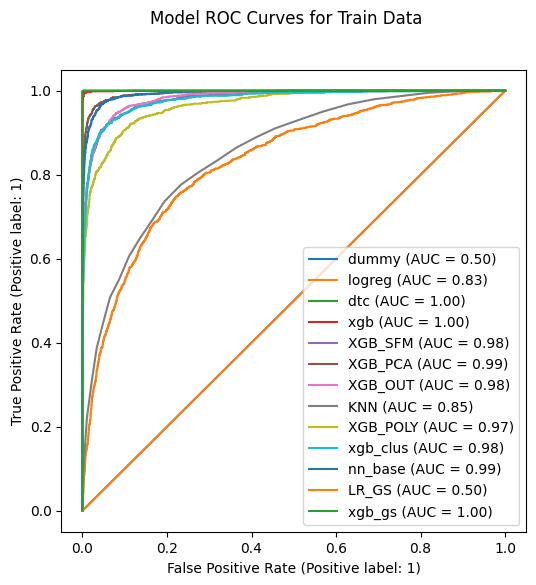

In [85]:
model_dict.plot_models_roc_curves('train')

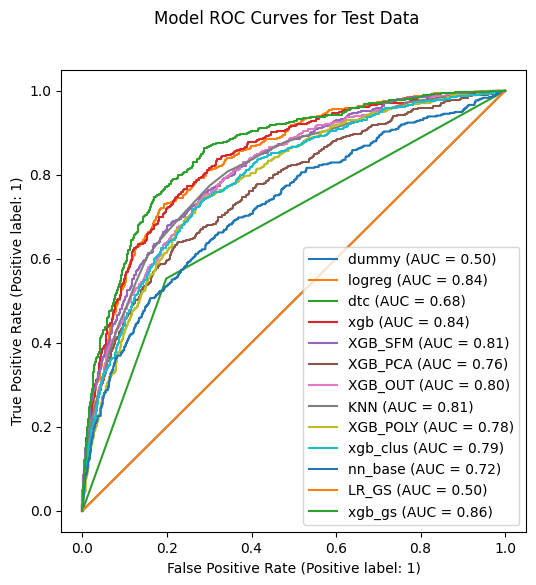

In [86]:
model_dict.plot_models_roc_curves('test')

In [87]:
model_dict.show_cv_results()

model                  CV Results
0     dummy  0.76785 ± 0.00991 accuracy
0    logreg  0.75332 ± 0.01661 accuracy
0       dtc  0.72536 ± 0.01128 accuracy
0       xgb  0.81331 ± 0.00668 accuracy
0   XGB_SFM  0.80472 ± 0.01418 accuracy
0   XGB_PCA  0.75879 ± 0.01146 accuracy
0   XGB_OUT  0.80550 ± 0.01111 accuracy
0       KNN  0.71474 ± 0.01439 accuracy
0  XGB_POLY  0.78207 ± 0.01480 accuracy
0  xgb_clus  0.79488 ± 0.01249 accuracy
0   nn_base  0.75785 ± 0.02023 accuracy
0     LR_GS  0.76785 ± 0.00991 accuracy
0    xgb_gs  0.81987 ± 0.00589 accuracy

**Observations**

The gridsearched XGBoost is still overfit but it has the best CV score. 

#### Neural Network
The neural network was overfit, let's see if I can imporove this model by using a classic binary classification solution with regularization

In [90]:
def create_optimized_nn():
# create model, inspiration https://www.atmosera.com/blog/binary-classification-with-neural-networks/
  model = Sequential()
  model.add(Dense(512, input_shape=(84,), activation='relu', kernel_regularizer=l2(l2=0.01)))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2=0.01)))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [91]:
nn_opt = KerasClassifier(model=create_optimized_nn, epochs=40, batch_size=10)

nn_opt_pipe = ImPipeline(steps=[
      ('ct', CT),
      ('sm',SMOTE(random_state=42)),
      ('pct',Pandas_CT()),
      ('nn',nn_opt)
  ])

# Create a saved model object
nn_opt_pipe_results = SaveModel(
    model=nn_opt_pipe,
    model_name='NN_OPT',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
nn_opt_pipe_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(nn_opt_pipe_results)

Epoch 1/40
983/983 [==============================] - 4s 2ms/step - loss: 0.8900 - accuracy: 0.7445
Epoch 2/40
983/983 [==============================] - 2s 2ms/step - loss: 0.5407 - accuracy: 0.7620
Epoch 3/40
983/983 [==============================] - 2s 2ms/step - loss: 0.5242 - accuracy: 0.7722
Epoch 4/40
983/983 [==============================] - 2s 2ms/step - loss: 0.5150 - accuracy: 0.7748
Epoch 5/40
983/983 [==============================] - 2s 2ms/step - loss: 0.5043 - accuracy: 0.7814
Epoch 6/40
983/983 [==============================] - 2s 2ms/step - loss: 0.5018 - accuracy: 0.7861
Epoch 7/40
983/983 [==============================] - 2s 2ms/step - loss: 0.4969 - accuracy: 0.7893
Epoch 8/40
983/983 [==============================] - 2s 2ms/step - loss: 0.4904 - accuracy: 0.7949
Epoch 9/40
983/983 [==============================] - 3s 3ms/step - loss: 0.4925 - accuracy: 0.7908
Epoch 10/40
983/983 [==============================] - 2s 2ms/step - loss: 0.4853 - accuracy: 0.7976

<ipython-input-26-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-26-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


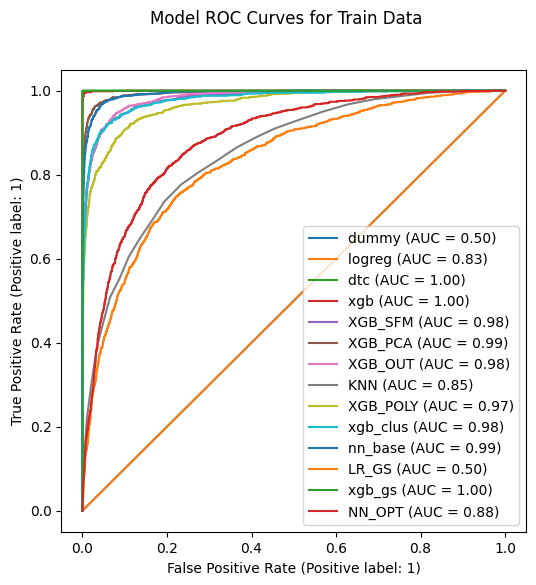

In [92]:
model_dict.plot_models_roc_curves('train')

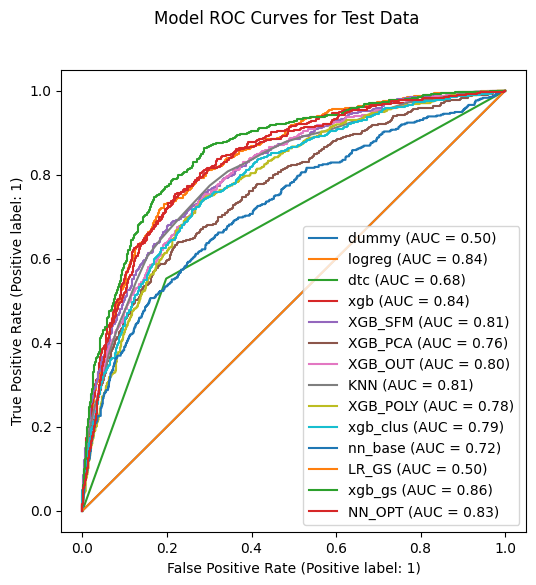

In [93]:
model_dict.plot_models_roc_curves('test')

In [94]:
model_dict.show_cv_results()

model                  CV Results
0     dummy  0.76785 ± 0.00991 accuracy
0    logreg  0.75332 ± 0.01661 accuracy
0       dtc  0.72536 ± 0.01128 accuracy
0       xgb  0.81331 ± 0.00668 accuracy
0   XGB_SFM  0.80472 ± 0.01418 accuracy
0   XGB_PCA  0.75879 ± 0.01146 accuracy
0   XGB_OUT  0.80550 ± 0.01111 accuracy
0       KNN  0.71474 ± 0.01439 accuracy
0  XGB_POLY  0.78207 ± 0.01480 accuracy
0  xgb_clus  0.79488 ± 0.01249 accuracy
0   nn_base  0.75785 ± 0.02023 accuracy
0     LR_GS  0.76785 ± 0.00991 accuracy
0    xgb_gs  0.81987 ± 0.00589 accuracy
0    NN_OPT  0.76426 ± 0.03806 accuracy

**Observations**

Sadly while this did reduce overfitting, the CV score is still low. This will not likely be the final model selected

### Feature Selection

#### XGBoost

First we need to create the pipeline with:
- Imputing
- Scaling
- One hot encoding
- Polynomial features
- Select from model (5 features to match MELD)
- Kmeans clustering
- XGBoost classifier (estimator)

In [95]:
# Set up Pipeline
grad_boost_xgb_gs_fs = XGBClassifier(random_state=42, objective='binary:logistic')

# Create the subpipe for the numeric variables
subpipe_numerics_xgb_gs_fs = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('sfm',SelectFromModel(XGBClassifier(random_state=42, objective='binary:logistic', nthread=-1), max_features=5))
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat_xgb_gs_fs = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

# Create the column transformer
CT_XGB_GS_FS = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics_xgb_gs_fs, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat_xgb_gs_fs, selector(dtype_include=object))
], remainder='passthrough')

# Create pipelines
xgb_gs_fs_pipe = ImPipeline(steps=[
        ('ct', CT_XGB_GS_FS),
        ('km', Kmean_cluster()),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_xgb_gs_fs)
    ])

In [96]:
params = {
 'xgb__learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'xgb__max_depth' : [2, 3, 4, 5, 6, 8, 10, 12, 15],
 'xgb__min_child_weight' : [ 1, 3, 5, 7 ],
 'xgb__gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'xgb__colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

gs_xgb_fs = RandomizedSearchCV(xgb_gs_fs_pipe,
                         params,
                         scoring = 'roc_auc',
                         verbose = 3,
                         random_state=42)
xgb_gs_fs = gs_xgb_fs.fit(X_train, y_train)
xgb_gs_fs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.717 total time=  30.3s
[CV 2/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.768 total time=  28.4s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.733 total time=  27.8s
[CV 4/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.760 total time=  26.3s
[CV 5/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.734 total time=  31.8s
[CV 1/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.15, xgb__max_depth=12, xgb__min_child_weight=1;, score=0.725 total time=  22.4s
[CV 2/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.15, xgb__max_depth=12, xgb__min_child_weight=1;, score=0.770 total time=  21.9s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.15, xgb__max_depth=12, xgb__min_child_weight=1;, score=0.743 total time=  26.4s
[CV 4/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.15, xgb__max_depth=12, xgb__min_child_weight=1;, score=0.764 total time=  30.5s
[CV 5/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.15, xgb__max_depth=12, xgb__min_child_weight=1;, score=0.742 total time=  25.8s
[CV 1/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.732 total time=  29.4s
[CV 2/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.769 total time=  26.5s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.747 total time=  29.6s
[CV 4/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.769 total time=  37.5s
[CV 5/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.753 total time=  28.3s
[CV 1/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=15, xgb__min_child_weight=5;, score=0.744 total time=  26.8s
[CV 2/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=15, xgb__min_child_weight=5;, score=0.774 total time=  35.1s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=15, xgb__min_child_weight=5;, score=0.757 total time=  31.4s
[CV 4/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=15, xgb__min_child_weight=5;, score=0.775 total time=  21.8s
[CV 5/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=15, xgb__min_child_weight=5;, score=0.751 total time=  19.3s
[CV 1/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.3, xgb__max_depth=10, xgb__min_child_weight=1;, score=0.721 total time=  19.3s
[CV 2/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.3, xgb__max_depth=10, xgb__min_child_weight=1;, score=0.752 total time=  27.0s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.3, xgb__max_depth=10, xgb__min_child_weight=1;, score=0.740 total time=  32.3s
[CV 4/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.3, xgb__max_depth=10, xgb__min_child_weight=1;, score=0.758 total time=  23.1s
[CV 5/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.3, xgb__max_depth=10, xgb__min_child_weight=1;, score=0.733 total time=  20.9s
[CV 1/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.25, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.751 total time=  24.7s
[CV 2/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.25, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.783 total time=  28.4s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.25, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.762 total time=  31.6s
[CV 4/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.25, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.776 total time=  28.1s
[CV 5/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.4, xgb__learning_rate=0.25, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.752 total time=  28.1s
[CV 1/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.746 total time=  25.3s
[CV 2/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.785 total time=  30.1s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.768 total time=  26.1s
[CV 4/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.778 total time=  27.4s
[CV 5/5] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=2, xgb__min_child_weight=7;, score=0.751 total time=  28.2s
[CV 1/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.0, xgb__learning_rate=0.2, xgb__max_depth=8, xgb__min_child_weight=5;, score=0.734 total time=  29.4s
[CV 2/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.0, xgb__learning_rate=0.2, xgb__max_depth=8, xgb__min_child_weight=5;, score=0.769 total time=  24.5s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.0, xgb__learning_rate=0.2, xgb__max_depth=8, xgb__min_child_weight=5;, score=0.755 total time=  30.9s
[CV 4/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.0, xgb__learning_rate=0.2, xgb__max_depth=8, xgb__min_child_weight=5;, score=0.771 total time=  26.9s
[CV 5/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.0, xgb__learning_rate=0.2, xgb__max_depth=8, xgb__min_child_weight=5;, score=0.733 total time=  25.3s
[CV 1/5] END xgb__colsample_bytree=0.4, xgb__gamma=0.2, xgb__learning_rate=0.25, xgb__max_depth=12, xgb__min_child_weight=3;, score=0.732 total time=  31.2s
[CV 2/5] END xgb__colsample_bytree=0.4, xgb__gamma=0.2, xgb__learning_rate=0.25, xgb__max_depth=12, xgb__min_child_weight=3;, score=0.759 total time=  34.4s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.4, xgb__gamma=0.2, xgb__learning_rate=0.25, xgb__max_depth=12, xgb__min_child_weight=3;, score=0.734 total time=  34.5s
[CV 4/5] END xgb__colsample_bytree=0.4, xgb__gamma=0.2, xgb__learning_rate=0.25, xgb__max_depth=12, xgb__min_child_weight=3;, score=0.756 total time=  30.2s
[CV 5/5] END xgb__colsample_bytree=0.4, xgb__gamma=0.2, xgb__learning_rate=0.25, xgb__max_depth=12, xgb__min_child_weight=3;, score=0.731 total time=  24.8s
[CV 1/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=3;, score=0.751 total time=  30.0s
[CV 2/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=3;, score=0.785 total time=  29.4s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=3;, score=0.761 total time=  30.0s
[CV 4/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=3;, score=0.774 total time=  27.5s
[CV 5/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=3;, score=0.738 total time=  27.3s


{'xgb__min_child_weight': 7,
 'xgb__max_depth': 2,
 'xgb__learning_rate': 0.2,
 'xgb__gamma': 0.3,
 'xgb__colsample_bytree': 0.5}

In [97]:
# Create a saved model object
xgb_pipe_gs_results = SaveModel(
    model=xgb_gs_fs.best_estimator_,
    model_name='xgb_gs_fm',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_pipe_gs_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(xgb_pipe_gs_results)

<ipython-input-26-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-26-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


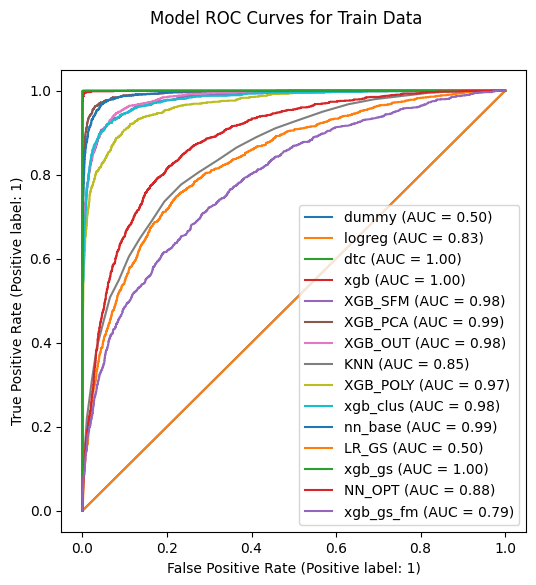

In [98]:
model_dict.plot_models_roc_curves('train')

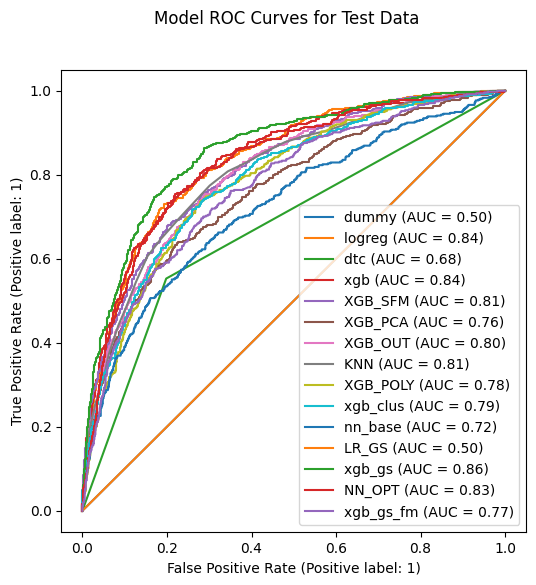

In [99]:
model_dict.plot_models_roc_curves('test')

In [100]:
model_dict.show_cv_results()

model                  CV Results
0      dummy  0.76785 ± 0.00991 accuracy
0     logreg  0.75332 ± 0.01661 accuracy
0        dtc  0.72536 ± 0.01128 accuracy
0        xgb  0.81331 ± 0.00668 accuracy
0    XGB_SFM  0.80472 ± 0.01418 accuracy
0    XGB_PCA  0.75879 ± 0.01146 accuracy
0    XGB_OUT  0.80550 ± 0.01111 accuracy
0        KNN  0.71474 ± 0.01439 accuracy
0   XGB_POLY  0.78207 ± 0.01480 accuracy
0   xgb_clus  0.79488 ± 0.01249 accuracy
0    nn_base  0.75785 ± 0.02023 accuracy
0      LR_GS  0.76785 ± 0.00991 accuracy
0     xgb_gs  0.81987 ± 0.00589 accuracy
0     NN_OPT  0.76426 ± 0.03806 accuracy
0  xgb_gs_fm  0.72755 ± 0.02600 accuracy

**Observations**

Reducing to 5 features dropped our cross validaiton score lower than the dummy model. This is not an acceptable final model

# Final Model Selection
Todo:
- Validate all models
- Save all models
- Select Final Model

## Model Validation

I'll start by training all the models on the train + test combined dataset and testing them on the validate data

In [104]:
model_dict.validate_models()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-27-6d1b5006f10e>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(
<ipython-input-26-1b579c8aabfd>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model_data[val_filter])
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as show

Epoch 1/40


<ipython-input-27-6d1b5006f10e>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(
<ipython-input-26-1b579c8aabfd>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model_data[val_filter])


1315/1315 [==============================] - 4s 2ms/step - loss: 0.8459 - accuracy: 0.7452
Epoch 2/40
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5405 - accuracy: 0.7571
Epoch 3/40
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5209 - accuracy: 0.7703
Epoch 4/40
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5120 - accuracy: 0.7767
Epoch 5/40
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5067 - accuracy: 0.7787
Epoch 6/40
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5003 - accuracy: 0.7824
Epoch 7/40
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5009 - accuracy: 0.7852
Epoch 8/40
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4973 - accuracy: 0.7852
Epoch 9/40
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4960 - accuracy: 0.7897
Epoch 10/40
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4915 - accurac

<ipython-input-27-6d1b5006f10e>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(
<ipython-input-26-1b579c8aabfd>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model_data[val_filter])
<ipython-input-27-6d1b5006f10e>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(
<ipython-input-26-1b579c8aabfd>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model_data[val_filter])


Now I will investigate performance on the unseen data

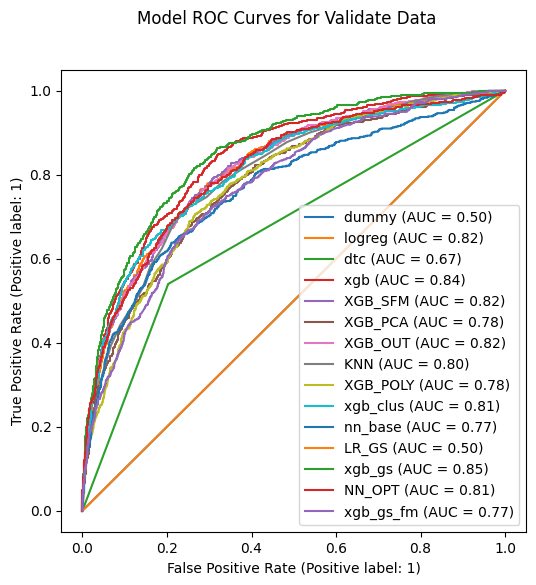

In [105]:
model_dict.plot_models_roc_curves('validate')

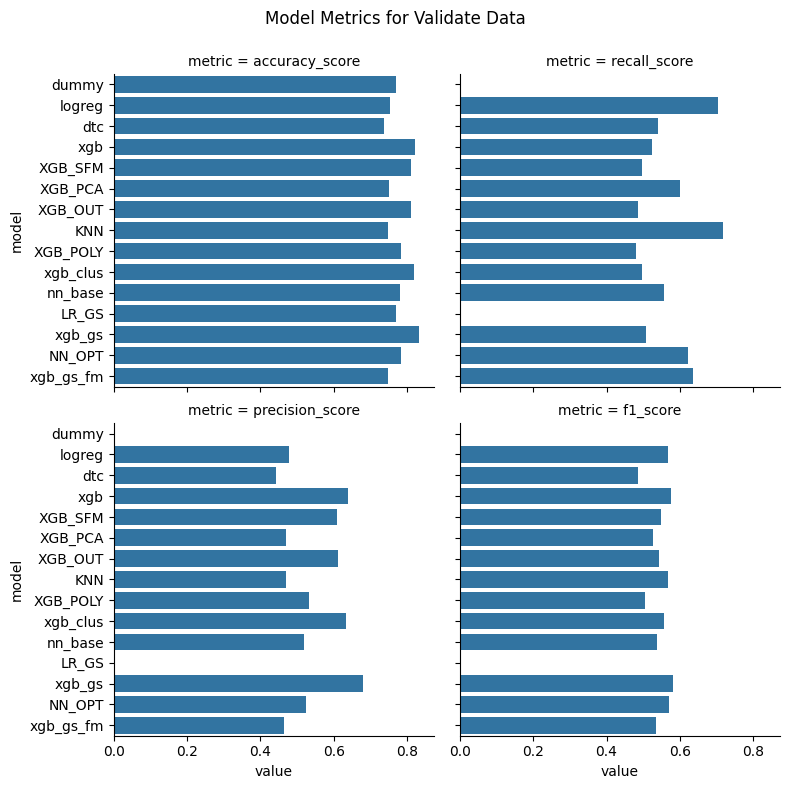

In [106]:
model_dict.plot_models_scores('validate')

In [119]:
model_dict.print_scores(metric='accuracy_score')

model   dataset          metric     value
0      dummy     train  accuracy_score  0.767849
4      dummy      test  accuracy_score  0.777882
0     logreg     train  accuracy_score  0.769723
4     logreg      test  accuracy_score  0.756326
0        dtc     train  accuracy_score  0.999844
4        dtc      test  accuracy_score  0.746485
0        xgb     train  accuracy_score  0.995001
4        xgb      test  accuracy_score  0.823336
0    XGB_SFM     train  accuracy_score  0.939228
4    XGB_SFM      test  accuracy_score  0.812559
0    XGB_PCA     train  accuracy_score  0.966724
4    XGB_PCA      test  accuracy_score  0.762418
0    XGB_OUT     train  accuracy_score  0.942197
4    XGB_OUT      test  accuracy_score  0.803187
0        KNN     train  accuracy_score  0.768942
4        KNN      test  accuracy_score  0.736645
0   XGB_POLY     train  accuracy_score  0.929542
4   XGB_POLY      test  accuracy_score  0.786785
0   xgb_clus     train  accuracy_score  0.943290
4   xgb_clus      test  accuracy_score  0.799438
0    nn_base     train  accuracy_score  0.963287
4    nn_base      test  accuracy_score  0.751640
0      LR_GS     train  accuracy_score  0.767849
4      LR_GS      test  accuracy_score  0.777882
0     xgb_gs     train  accuracy_score  0.999375
4     xgb_gs      test  accuracy_score  0.830834
0     NN_OPT     train  accuracy_score  0.786752
4     NN_OPT      test  accuracy_score  0.749766
0  xgb_gs_fm     train  accuracy_score  0.733167
4  xgb_gs_fm      test  accuracy_score  0.731959
0      dummy  validate  accuracy_score  0.769852
0     logreg  validate  accuracy_score  0.754392
0        dtc  validate  accuracy_score  0.737878
0        xgb  validate  accuracy_score  0.822207
0    XGB_SFM  validate  accuracy_score  0.810611
0    XGB_PCA  validate  accuracy_score  0.751230
0    XGB_OUT  validate  accuracy_score  0.810963
0        KNN  validate  accuracy_score  0.748067
0   XGB_POLY  validate  accuracy_score  0.783556
0   xgb_clus  validate  accuracy_score  0.818342
0    nn_base  validate  accuracy_score  0.779691
0      LR_GS  validate  accuracy_score  0.769852
0     xgb_gs  validate  accuracy_score  0.831342
0     NN_OPT  validate  accuracy_score  0.782853
0  xgb_gs_fm  validate  accuracy_score  0.746662

**Observations**
- XGBoost performed well on the validation set
- Outlier handling is only a marginal improvement over SFM

## Save Models

So I don't have to rerun the models everytime I will save the models in pickle files

In [117]:
DATA_PATH = "/content/drive/MyDrive/Flatiron/phase_5/colab/models/"

for model in model_dict.models:
  artifact_filename = model + '.pkl'
  # Save model artifact to local filesystem (doesn't persist)
  local_path = DATA_PATH + artifact_filename
  with open(local_path, 'wb') as model_file:
    pickle.dump(model_dict.models[model].model, model_file)

In [120]:
# Test that out, too!
# Loading up our best performing model
example_model = 'xgb_gs.pkl'
new_path = DATA_PATH + example_model
with open(new_path, 'rb') as f:
    loaded_model = pickle.load(f)

In [123]:
loaded_model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f74a0be5930>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))...
                               feature_types=None, gamma=0.2, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=5, missing=nan,
                               monotone_constraints=None, n_estimators=600,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [121]:
X[:1]

race gender  age  hematocrit_min  hematocrit_max  hemoglobin_min  \
0  WHITE      M   36            32.4            35.5            11.1   

   hemoglobin_max  platelets_min  platelets_max  wbc_min  ...  ptt_min  \
0            12.0          183.0          222.0      4.0  ...     28.8   

   ptt_max  alt_min  alt_max  alp_min  alp_max  ast_min  ast_max  \
0     28.8     45.0     45.0    105.0    105.0     86.0     86.0   

   bilirubin_total_min  bilirubin_total_max  
0                  0.5                  0.5  

[1 rows x 53 columns]

In [122]:
# Example predictions on just one
loaded_model.predict(X[:1])

array([0])

## Selecting the Final Model

Why I selected this model as the final model:
- High accuracy score on validation data (0.818)
- High AUC score on validation data (0.81)
- Few features (10)

What is included in this model?
- Imputing
- Scaling
- One hot encoding
- Select from model (10 features)
- Kmeans clustering
- SMOTE
- XGBoost classifier (estimator)

In [125]:
# Loading up our final model
final_model_name = 'xgb_clus.pkl'
new_path = DATA_PATH + final_model_name
with open(new_path, 'rb') as f:
    final_model = pickle.load(f)

In [126]:
final_model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler()),
                                                                  ('sfm',
                                                                   SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                                                                           booster=None,
                                                                                                           callbacks=None,
                                                                                                           colsample_bylevel=None,
                                                                                                           colsample_bynode=None,
                                                                                                           colsample_bytree=None,
                                                                                                           early_stopp...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='reg:squarederror', predictor=None, ...))])

Let's take another look at the top features

In [127]:
xgb_features = pd.DataFrame()

y = model_dict.models['xgb_clus'].model.named_steps.ct.get_feature_names_out()
y = [val.split("__")[1] for val in y]
y.append('Kmeans Cluster')
xgb_features['feature'] = y

xgb_features['importance'] = pd.DataFrame(model_dict.models['xgb_clus'].model.named_steps.xgb.feature_importances_).astype(float)[0]

xgb_features = xgb_features.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(data=xgb_features, y='feature', x='importance', ax=ax);

# Conclusion

My goal was to create a model that performed better than MELD on this dataset. Meld C-statistic (AUC) was 0.76 and I was able to select a model that performed better than MELD, although I did end up having to use more features (10 or more).

The best performing model I created was XGBoost utilizing many data science tools including scaling, encoding, imputing, clustering, smote, and selecting top features from a model.

**Recommendations**
- Automate model calculation from LAB results to improve accuracy (more features)
- Investigate adding race to calculator
- Implement selected model in MELD calculator

**Analysis Next Steps**
- Investigate performance of model for different races to determine existance of bias
- Work with medical professional to improve Cohort selection and model interpretation
- Use OPTN data to investigate if model could replace MELD for liver transplant prioritization